# Capstone Projects
## Employees Salary Compensation


### Problem Statement

In [1]:
# import libraries

# For data wrangling
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# display plots in the notebook
%matplotlib inline

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# hyperparameters tuning, data splitting libraries (support function)
from sklearn.model_selection import train_test_split, GridSearchCV

# Explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting

# machine learning model (fit models)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor,\
AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import pickle

# evaluation and adjustment of the model (scoring function)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import feature_importances

import warnings
warnings.filterwarnings("ignore")

In [2]:
# manipulate function for feature importance plot

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({"Percentage":(model.feature_importances_ / sum(model.feature_importances_) * 100),
                                "Feature":X.columns})
    plt.figure(figsize=(40,20))
    sns.set(font_scale = 4)
    sns.barplot(x="Percentage", y="Feature", data=feature_imp.sort_values(by="Percentage", 
                                                        ascending=False)[0:num])
    plt.title('Extra Trees Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

### Download Dataset

In [4]:
# load the dataset

emp_sal = pd.read_csv("Employee_Salary_Compensation.csv")
emp_sal.head() # an overview of the dataset

,Organization Group Code,Job Family Code,Job Code,Year Type,Year,Organization Group,Department Code,Department,Union Code,Union,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
0,1,1000,1021,Calendar,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",...,37730,57534.65,0.0,0.00,57534.65,11253.16,11961.34,4532.63,27747.13,85281.78
1,1,1000,1023,Calendar,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",...,26574,57678.50,0.0,0.00,57678.50,10284.88,7176.80,4755.14,22216.82,79895.32
2,1,1000,1031,Calendar,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",...,8148,63532.93,0.0,0.00,63532.93,12495.83,12918.24,4702.71,30116.78,93649.71
3,1,1000,1054,Calendar,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",...,27436,101274.51,0.0,-7058.59,94215.92,19644.45,12918.24,7458.76,40021.45,134237.37
4,1,1000,1062,Calendar,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",...,37730,5084.00,0.0,0.00,5084.00,1083.90,956.91,387.50,2428.31,7512.31


### Explore Dataset

In [5]:
# Overview of the dataset

emp_sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678524 entries, 0 to 678523
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Organization Group Code  678524 non-null  int64  
 1   Job Family Code          678524 non-null  object 
 2   Job Code                 678524 non-null  object 
 3   Year Type                678524 non-null  object 
 4   Year                     678524 non-null  int64  
 5   Organization Group       678524 non-null  object 
 6   Department Code          678522 non-null  object 
 7   Department               678522 non-null  object 
 8   Union Code               678345 non-null  float64
 9   Union                    678345 non-null  object 
 10  Job Family               678524 non-null  object 
 11  Job                      678519 non-null  object 
 12  Employee Identifier      678524 non-null  int64  
 13  Salaries                 678524 non-null  float64
 14  Over

#### Description of the Attributes from the Dataset

| Attributes      | Description  |
| :-------------- | :------------|
| Organization Group Code     | Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police, Fire, Adult Probation, District Attorney, and Sheriff |
| Job Family Code       | Job Family combines similar Jobs into meaningful groups |
| Job Code | Jobs are defined by the Human Resources classification unit. Examples include gardeners, police officers, and accountants. |
| Year Type | Fiscal (July through June) or Calendar (January through December) |
| Year | An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012 |
| Organization Group   |  Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police, Fire, Adult Probation, District Attorney, and Sheriff |
| Department Code  | Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department |
| Department | Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department |
| Union Code | Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily). |
| Union | Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).   |
| Job Family | Job Family combines similar Jobs into meaningful groups.  |
| Job        | Jobs are defined by the Human Resources classification unit. Examples include gardeners, police officers, and accountants.  |
| Employee Identifier | Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the Employee Compensation report hosted on openbook.sfgov.org, but that report does show one row for each employee. Employee ID has been included here to allow users to reconstruct the original report. Note that each employee’s identifier will change each time this dataset is updated, so comparisons by employee across multiple versions of the dataset are not possible.   |
| Salaries | Normal salaries paid to permanent or temporary City employees.  |
| Overtime | Amounts paid to City employees working in excess of 40 hours per week.    |
| Other Salaries  | Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments.  |
| Total Salary | The sum of all salaries paid to City employees.   |
| Retirement | City contributions to employee retirement plans.   |
| Health and Dental | City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.     |
| Other Benefits   | Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment insurance premiums, and minor discretionary benefits not included in the above categories.    |
| Total Benefits   | The sum of all benefits paid to City employees.   |
| Total Compensation | The sum of all salaries and benefits paid to City employees.  |

In [6]:
# look for unique value of each columns

emp_sal.nunique()

Organization Group Code         7
Job Family Code                59
Job Code                     1211
Year Type                       2
Year                            8
Organization Group              7
Department Code                60
Department                    109
Union Code                     70
Union                         128
Job Family                     59
Job                          1349
Employee Identifier        322178
Salaries                   497610
Overtime                   266218
Other Salaries             307561
Total Salary               613748
Retirement                 452677
Health and Dental          208405
Other Benefits             495763
Total Benefits             613267
Total Compensation         654483
dtype: int64

In [7]:
# differentiate the count of Organization Group by Year Type

emp_count = emp_sal.groupby(["Organization Group","Year Type"]).size()
emp_count

Organization Group                        Year Type
Community Health                          Calendar      75074
                                          Fiscal        74694
Culture & Recreation                      Calendar      29979
                                          Fiscal        31261
General Administration & Finance          Calendar      31155
                                          Fiscal        30837
General City Responsibilities             Calendar        216
                                          Fiscal          177
Human Welfare & Neighborhood Development  Calendar      30329
                                          Fiscal        30356
Public Protection                         Calendar      65153
                                          Fiscal        65017
Public Works, Transportation & Commerce   Calendar     107198
                                          Fiscal       107078
dtype: int64

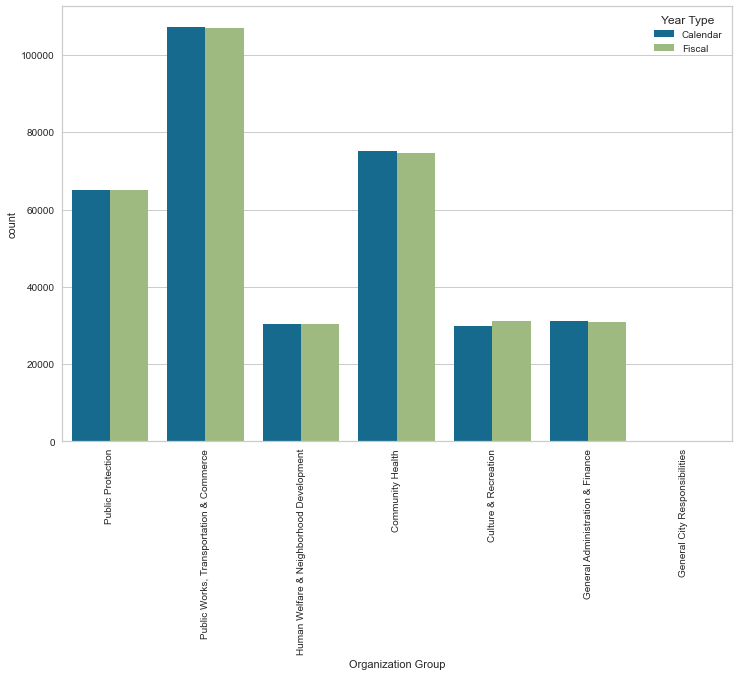

In [8]:
# plot employee count by organization group from different type of year

plt.figure(figsize = (12,8))
sns.countplot (x = "Organization Group" , hue = "Year Type", data = emp_sal)
plt.xticks(rotation = 90)
plt.show()

In [9]:
# before drop, check on the size between the 2 year type

emp_sal.groupby("Year Type").size()

Year Type
Calendar    339104
Fiscal      339420
dtype: int64

In [10]:
# drop the rows of "Calendar"

emp_sal_fiscal = emp_sal[emp_sal["Year Type"] == "Fiscal"]

In [11]:
# Confirm the size before and after drop

emp_sal_fiscal["Year Type"].value_counts()

Fiscal    339420
Name: Year Type, dtype: int64

In [12]:
# drop unwanted columns 

emp_sal_fiscal = emp_sal_fiscal.drop(["Year Type","Employee Identifier"],axis=1)

In [13]:
# check on "General City Responsibilities" records

gcr_dept = emp_sal_fiscal.loc[emp_sal_fiscal["Organization Group"].isin(["General City Responsibilities"])]

gcr_dept


,Organization Group Code,Job Family Code,Job Code,Year,Organization Group,Department Code,Department,Union Code,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
378441,7,900,904,2013,General City Responsibilities,UNA,GEN General City / Unallocated,2.0,Management Unrepresented Employees,Management,Mayoral Staff XVI,28186.14,0.00,0.00,28186.14,4991.76,2954.26,1956.35,9902.37,38088.51
378442,7,7200,7216,2013,General City Responsibilities,UNA,GEN General City / Unallocated,6.0,"Electrical Workers, Local 6",Supervisory-Labor & Trade,Electrical Trnst Shop Sprv 1,0.00,0.00,857.20,857.20,0.00,0.00,65.58,65.58,922.78
378443,7,1000,1054,2013,General City Responsibilities,UNA,GEN General City / Unallocated,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Business Analyst-Principal,134.50,0.00,0.00,134.50,0.00,0.00,10.62,10.62,145.12
378444,7,1300,1314,2013,General City Responsibilities,UNA,GEN General City / Unallocated,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Pub Relations & Spec Assts,Public Relations Officer,4383.65,0.00,0.00,4383.65,793.00,0.00,346.31,1139.31,5522.96
378445,7,5200,5201,2013,General City Responsibilities,UNA,GEN General City / Unallocated,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Professional Engineering,Junior Engineer,1523.50,0.00,8547.60,10071.10,0.00,0.00,3.81,3.81,10074.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506610,7,3200,3284,2016,General City Responsibilities,UNA,GEN General City / Unallocated,790.0,"SEIU - Miscellaneous, Local 1021",Recreation,Recreation Director,0.00,0.00,4639.79,4639.79,0.00,0.00,354.94,354.94,4994.73
506611,7,3200,3284,2016,General City Responsibilities,UNA,GEN General City / Unallocated,790.0,"SEIU - Miscellaneous, Local 1021",Recreation,Recreation Director,0.00,0.00,3302.81,3302.81,0.00,0.00,252.66,252.66,3555.47
506612,7,3200,3284,2016,General City Responsibilities,UNA,GEN General City / Unallocated,790.0,"SEIU - Miscellaneous, Local 1021",Recreation,Recreation Director,0.00,0.00,4063.31,4063.31,0.00,0.00,310.85,310.85,4374.16
548799,7,8300,8300,2017,General City Responsibilities,NaN,NaN,790.0,"SEIU, Local 1021, Misc",Correction & Detention,Sheriff's Cadet,49630.50,15016.51,4575.73,67844.53,10619.27,12779.88,4796.56,28195.71,96040.24


In [14]:
# drop Organization Group - General City Responsibilities

emp_sal_fiscal = emp_sal_fiscal.loc[(emp_sal_fiscal["Organization Group"] != "General City Responsibilities")]


In [15]:
# check dataframe after drop unwanted column and rows

emp_sal_fiscal.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339243 entries, 339104 to 678523
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Organization Group Code  339243 non-null  int64  
 1   Job Family Code          339243 non-null  object 
 2   Job Code                 339243 non-null  object 
 3   Year                     339243 non-null  int64  
 4   Organization Group       339243 non-null  object 
 5   Department Code          339243 non-null  object 
 6   Department               339243 non-null  object 
 7   Union Code               339200 non-null  float64
 8   Union                    339200 non-null  object 
 9   Job Family               339243 non-null  object 
 10  Job                      339239 non-null  object 
 11  Salaries                 339243 non-null  float64
 12  Overtime                 339243 non-null  float64
 13  Other Salaries           339243 non-null  float64
 14 

In [16]:
# check the number of unique values

emp_sal_fiscal.nunique() 

Organization Group Code         6
Job Family Code                59
Job Code                     1207
Year                            8
Organization Group              6
Department Code                58
Department                    106
Union Code                     70
Union                         128
Job Family                     59
Job                          1341
Salaries                   257642
Overtime                   143115
Other Salaries             171292
Total Salary               314782
Retirement                 236436
Health and Dental          108873
Other Benefits             285044
Total Benefits             319174
Total Compensation         331838
dtype: int64

In [17]:
# check whether have duplicate values 

print("Duplicated data:", emp_sal_fiscal.duplicated().sum())

Duplicated data: 3272


In [18]:
# checking for missing values

print(emp_sal_fiscal.isnull().sum())

Organization Group Code     0
Job Family Code             0
Job Code                    0
Year                        0
Organization Group          0
Department Code             0
Department                  0
Union Code                 43
Union                      43
Job Family                  0
Job                         4
Salaries                    0
Overtime                    0
Other Salaries              0
Total Salary                0
Retirement                  0
Health and Dental           0
Other Benefits              0
Total Benefits              0
Total Compensation          0
dtype: int64


#### Summary 

Based on overview of dataset, we have realised that there are 2 different "Year Type". Hence we make a comparison from the "Year Type" and we can see that there is no variance between Calendar and Fiscal. Due to forecasting will only based on Fiscal (Financial Year) values hence we will be dropping "Calendar" year type for further insights.

We will drop the feature after removing one of the value from "Year Type" that it is not useful for in predictive task. However, we will keep the duplicate features as we need the "code" for our matching missing values and standardize the value from the dataset. 

Besides that, we have observed that among all Organization Group, General City Responsibilities have the lowest count and it is lower than five hundreds. In this scenario, we check on the details and it show that the department was unallocated. Consider that the records is only 0.05% of the dataset and we will also drop this Organization Group for further insights. 

As we can see that same feature, code and naming have different number of unique values. We may have one code having similar values and we are to standardize it before we can proceed to analyse our data and predictive model.

After dropping all the unwanted rows and features, there are duplicate records that need to be dropped. There are also missing value from 3 different features that need to fill up based on the code and values after standardize.


### Data Cleaning

##### Drop duplicate rows and keep the last records

In [19]:
emp_sal_fiscal.drop_duplicates(keep = "last")

,Organization Group Code,Job Family Code,Job Code,Year,Organization Group,Department Code,Department,Union Code,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
339104,1,1000,1021,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Administrator 1,58368.56,0.0,0.0,58368.56,10628.94,12801.79,5254.13,28684.86,87053.42
339105,1,1000,1023,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Administrator 3,99944.00,0.0,0.0,99944.00,17700.03,12801.79,8311.72,38813.54,138757.54
339106,1,1000,1031,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Trainer-Assistant,59585.91,0.0,0.0,59585.91,10850.65,12801.79,4461.25,28113.69,87699.60
339107,1,1000,1054,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Business Analyst-Principal,65100.00,0.0,0.0,65100.00,11529.18,8616.59,5139.40,25285.17,90385.17
339108,1,1000,1070,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Project Director,134251.77,0.0,0.0,134251.77,23775.87,12801.79,9733.22,46310.88,180562.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678519,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Investigator, Tax Collector",98444.94,0.0,0.0,98444.94,20540.24,15275.18,8019.49,43834.91,142279.85
678520,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Investigator, Tax Collector",9416.71,0.0,0.0,9416.71,1904.43,1468.77,743.51,4116.71,13533.42
678521,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Investigator, Tax Collector",96475.00,0.0,576.0,97051.00,20241.56,14100.16,7897.00,42238.72,139289.72
678522,6,4300,4337,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",115943.00,0.0,0.0,115943.00,24188.37,15275.18,9018.34,48481.89,164424.89


#####  Check on missing value rows 

In [20]:
# check on the rows of missing values from "Job"

emp_sal_fiscal.loc[emp_sal["Job"].isnull()].T

,535421,542571,544862,577950
Organization Group Code,4,5,5,4
Job Family Code,900,2600,3300,900
Job Code,2246,2652,3320,2246
Year,2017,2017,2017,2018
Organization Group,Community Health,Culture & Recreation,Culture & Recreation,Community Health
Department Code,DPH,REC,REC,DPH
Department,Public Health,Recreation And Park Commission,Recreation And Park Commission,Public Health
Union Code,351.0,250.0,856.0,351.0
Union,"Municipal Exec Assoc, Misc","SEIU, Local 1021, Misc","Teamsters, Local 856, Multi","Municipal Exec Assoc, Misc"
Job Family,Management,Dietary & Food,Park & Zoo,Management


In [21]:
# create a dataframe by dropping the rows which is missing the "Job"

emp_dept_nan = emp_sal_fiscal.dropna(subset = ["Job"])

## check whhether is the nan rows have drop
# emp_dept_nan

In [22]:
# create a dictionary contains of job and job code

job_dict = dict(zip(emp_sal_fiscal["Job Code"],emp_dept_nan["Job"]))

## check on the dict data
# job_dict

In [23]:
# map "Job" using the dictionary and replace missing values by "Job Code"

emp_sal_fiscal["Job"] = emp_sal_fiscal["Job Code"].map(job_dict)

In [24]:
# create a dataframe by dropping the rows which is missing the "Union" & "Union Code"

emp_union_nan = emp_sal_fiscal.dropna(subset = ["Union Code","Union"])
emp_union_nan

,Organization Group Code,Job Family Code,Job Code,Year,Organization Group,Department Code,Department,Union Code,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
339104,1,1000,1021,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Administrator 1,58368.56,0.0,0.0,58368.56,10628.94,12801.79,5254.13,28684.86,87053.42
339105,1,1000,1023,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Administrator 3,99944.00,0.0,0.0,99944.00,17700.03,12801.79,8311.72,38813.54,138757.54
339106,1,1000,1031,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Business Analyst-Principal,59585.91,0.0,0.0,59585.91,10850.65,12801.79,4461.25,28113.69,87699.60
339107,1,1000,1054,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Project Director,65100.00,0.0,0.0,65100.00,11529.18,8616.59,5139.40,25285.17,90385.17
339108,1,1000,1070,2013,Public Protection,ADP,ADP Adult Probation,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,Technology Expert I,134251.77,0.0,0.0,134251.77,23775.87,12801.79,9733.22,46310.88,180562.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678519,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",98444.94,0.0,0.0,98444.94,20540.24,15275.18,8019.49,43834.91,142279.85
678520,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",9416.71,0.0,0.0,9416.71,1904.43,1468.77,743.51,4116.71,13533.42
678521,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",96475.00,0.0,576.0,97051.00,20241.56,14100.16,7897.00,42238.72,139289.72
678522,6,4300,4337,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790.0,"SEIU, Local 1021, Misc",Revenue,IS Business Analyst-Principal,115943.00,0.0,0.0,115943.00,24188.37,15275.18,9018.34,48481.89,164424.89


In [25]:
# create a dictionary after dropping missing values row

union_dict = dict(zip(emp_union_nan["Union Code"],emp_union_nan["Union"]))

## check on the dict data
# union_dict

In [26]:
# standardize values in "Union" in df after dropping missing values

emp_union_nan["Union"] = emp_union_nan["Union Code"].map(union_dict)

In [27]:
# create dictionary by Job and Union Code

job_union_code = dict(zip(emp_union_nan["Job"],emp_union_nan["Union Code"]))

## check on the dict data
# job_union_code

In [28]:
# replacing missing values in Union Code by "Job"

emp_sal_fiscal["Union Code"] = emp_sal_fiscal["Job"].map(job_union_code)

In [29]:
# standardize values for "Union"

emp_sal_fiscal["Union"] = emp_sal_fiscal["Union Code"].map(union_dict)

In [30]:
# convert float to integer for "union code"

emp_sal_fiscal["Union Code"] = emp_sal_fiscal["Union Code"].astype(int)

In [31]:
# create a dictionary contains of department code and department

dept_dict = dict(zip(emp_sal_fiscal["Department Code"],emp_sal_fiscal["Department"]))

## check on the dict data
# dept_dict

In [32]:
# Creates a sorted dictionary (sorted by key)

from collections import OrderedDict

sorted_dept_dict = OrderedDict(sorted(dept_dict.items()))
sorted_dept_dict

OrderedDict([('AAM', 'Asian Art Museum'),
             ('ADM', 'Administrative Services'),
             ('ADP', 'Adult Probation'),
             ('AIR', 'Airport Commission'),
             ('ART', 'Art Commission'),
             ('ASR', 'Assessor'),
             ('BOA', 'Board Of Appeals'),
             ('BOS', 'Board Of Supervisors'),
             ('CAT', 'City Attorney'),
             ('CFC', 'Children & Families Commission'),
             ('CHF', 'Children Youth & Families'),
             ('CII', 'CII Commty Invest & Infrstrctr'),
             ('CON', 'Controller'),
             ('CPC', 'City Planning'),
             ('CRT', 'Trial Courts'),
             ('CSC', 'Civil Service Commission'),
             ('CSS', 'Child Support Services'),
             ('CWP', 'WWE Wastewater Enterprise'),
             ('DAT', 'District Attorney'),
             ('DBI', 'Building Inspection'),
             ('DEM', 'Dept of Emergency Management'),
             ('DPA', 'Dept of Police Accountablility'),


In [33]:
# map "Department" using the dictionary have created by "Department Code"

emp_sal_fiscal["Department"] = emp_sal_fiscal["Department Code"].map(dept_dict)

In [34]:
# check on unique values from "Job Family Code"

emp_sal_fiscal["Job Family Code"].value_counts()

2300              35481
9100              28233
Q000              21057
7300              19894
2900              17348
9900              16030
1400              14788
H000              13901
2700              11102
900               10321
3200              10241
1800               9940
8200               9907
5200               9771
8300               8957
1000               8302
8100               7598
2500               6939
1600               6717
3600               6227
2400               5837
1200               4916
5300               4529
7500               4449
3400               3645
0                  3418
9200               3287
7200               3280
7400               2863
2200               2558
9700               2507
2600               2482
SCRT               2355
1900               1881
6300               1838
8400               1589
4200               1530
1300               1446
5600               1414
2800               1411
2100               1311
1700            

In [35]:
# check on unique values from "Job Family"

emp_sal_fiscal["Job Family"].value_counts()

Nursing                           35481
Street Transit                    28233
Police Services                   21057
Journeyman Trade                  19894
Human Services                    17348
Public Service Aide               16030
Clerical, Secretarial & Steno     14788
Fire Services                     13901
Housekeeping & Laundry            11102
Management                        10321
Recreation                        10241
Budget, Admn & Stats Analysis      9940
Protection & Apprehension          9907
Professional Engineering           9771
Correction & Detention             8957
Information Systems                8302
Legal & Court                      7598
Med Therapy & Auxiliary            6939
Payroll, Billing & Accounting      6717
Library                            6227
Lab, Pharmacy & Med Techs          5837
Personnel                          4916
Sub-Professional Engineering       4529
Semi-Skilled & General Labor       4449
Agriculture & Horticulture         3645


In [36]:
# create a new df to exclude not categorise value from "Job Family"

job_family_nan = emp_sal_fiscal.loc[(emp_sal_fiscal["Job Family"] != "Unassigned") & (emp_sal_fiscal["Job Family"] != "Untitled")]
job_family_nan

,Organization Group Code,Job Family Code,Job Code,Year,Organization Group,Department Code,Department,Union Code,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
339104,1,1000,1021,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Information Systems,IS Administrator 1,58368.56,0.0,0.0,58368.56,10628.94,12801.79,5254.13,28684.86,87053.42
339105,1,1000,1023,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Information Systems,IS Administrator 3,99944.00,0.0,0.0,99944.00,17700.03,12801.79,8311.72,38813.54,138757.54
339106,1,1000,1031,2013,Public Protection,ADP,Adult Probation,790,"SEIU, Local 1021, Misc",Information Systems,IS Business Analyst-Principal,59585.91,0.0,0.0,59585.91,10850.65,12801.79,4461.25,28113.69,87699.60
339107,1,1000,1054,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Information Systems,IS Project Director,65100.00,0.0,0.0,65100.00,11529.18,8616.59,5139.40,25285.17,90385.17
339108,1,1000,1070,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Information Systems,Technology Expert I,134251.77,0.0,0.0,134251.77,23775.87,12801.79,9733.22,46310.88,180562.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678519,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",98444.94,0.0,0.0,98444.94,20540.24,15275.18,8019.49,43834.91,142279.85
678520,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",9416.71,0.0,0.0,9416.71,1904.43,1468.77,743.51,4116.71,13533.42
678521,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",96475.00,0.0,576.0,97051.00,20241.56,14100.16,7897.00,42238.72,139289.72
678522,6,4300,4337,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,IS Business Analyst-Principal,115943.00,0.0,0.0,115943.00,24188.37,15275.18,9018.34,48481.89,164424.89


In [37]:
# to create dictionary for Job Family

job_family_dict = dict(zip(job_family_nan["Job Family Code"],job_family_nan["Job Family"]))

## check on the dict data
# job_family_dict

In [38]:
# create dictionary based on Union for Job Family Code

job_family_code = dict(zip(job_family_nan["Union"],job_family_nan["Job Family Code"]))

## check on the dict data
# job_family_code

In [39]:
# To map "Job Family Code"

emp_sal_fiscal["Job Family Code"] = emp_sal_fiscal["Union"].map(job_family_code)

In [40]:
# to map "Job Family"

emp_sal_fiscal["Job Family"] = emp_sal_fiscal["Job Family Code"].map(job_family_dict)

In [41]:
# to check whether unassigned job family code have replace successfully

emp_sal_fiscal["Job Family"].value_counts()

Revenue                           133163
Legal & Court                      48611
Street Transit                     30555
Public Health                      26350
Police Services                    20896
Fire Services                      13861
Management                         13107
Skilled Labor                       9906
Journeyman Trade                    9012
Semi-Skilled & General Labor        7381
Correction & Detention              6997
SF Superior Court                   4506
Public Service Aide                 3502
Supervisory-Labor & Trade           3056
Med Therapy & Auxiliary             2109
Probation & Parole                  1291
Nursing                             1208
Museum & Cultural Affairs            982
Port Operation                       714
Personnel                            698
Park & Zoo                           673
Computer Operatns & Repro Svcs       520
Construction Inspection              140
Medical & Dental                       5
Name: Job Family

In [42]:
# to check and confirm again is there any missing values

print(emp_sal_fiscal.isnull().sum())

Organization Group Code    0
Job Family Code            0
Job Code                   0
Year                       0
Organization Group         0
Department Code            0
Department                 0
Union Code                 0
Union                      0
Job Family                 0
Job                        0
Salaries                   0
Overtime                   0
Other Salaries             0
Total Salary               0
Retirement                 0
Health and Dental          0
Other Benefits             0
Total Benefits             0
Total Compensation         0
dtype: int64


Data cleaning that was done: 
* replace missing value from Department, Union, Union Code and Job.
* replace values of "unassigned" and "untitled" from "Job Family" by using the same group of union and map accordingly. 
* standardize the values of Job, Job Family and Union by creating dictionary based on the feature code respectively and map according to the dictionary that was created respectively.


### Descriptive Analysis

In [43]:
# group column by category 

numerical = emp_sal_fiscal.select_dtypes(include = ["float"])
categorical = ["Organization Group","Job Family","Union","Job","Department"]

In [44]:
# Outlier Observation Analysis

for feature in numerical:
    
    Q1 = emp_sal[feature].quantile(0.25)
    Q3 = emp_sal[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if emp_sal[(emp_sal[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Salaries yes
Overtime yes
Other Salaries yes
Total Salary yes
Retirement yes
Health and Dental yes
Other Benefits yes
Total Benefits yes
Total Compensation yes


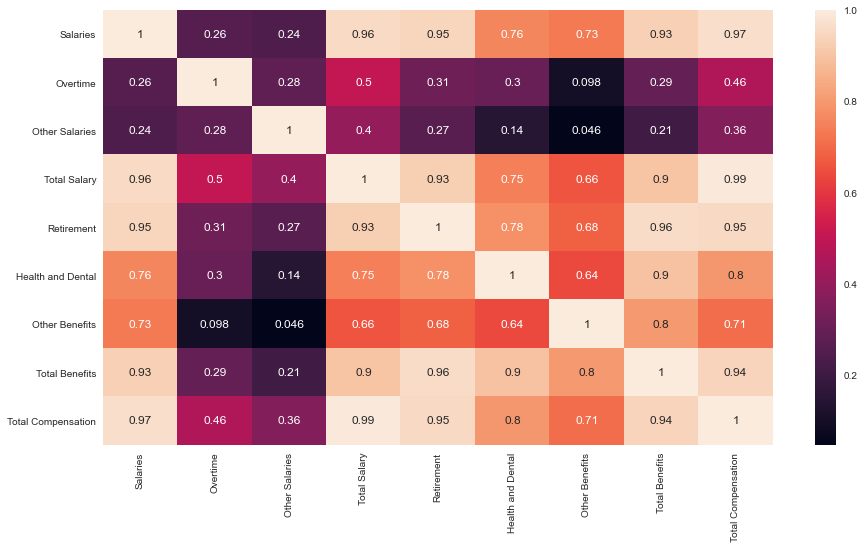

In [45]:
# correlation between numerical variables

plt.figure(figsize=(15,8))
sns.heatmap(numerical.corr(), annot=True)

plt.show()

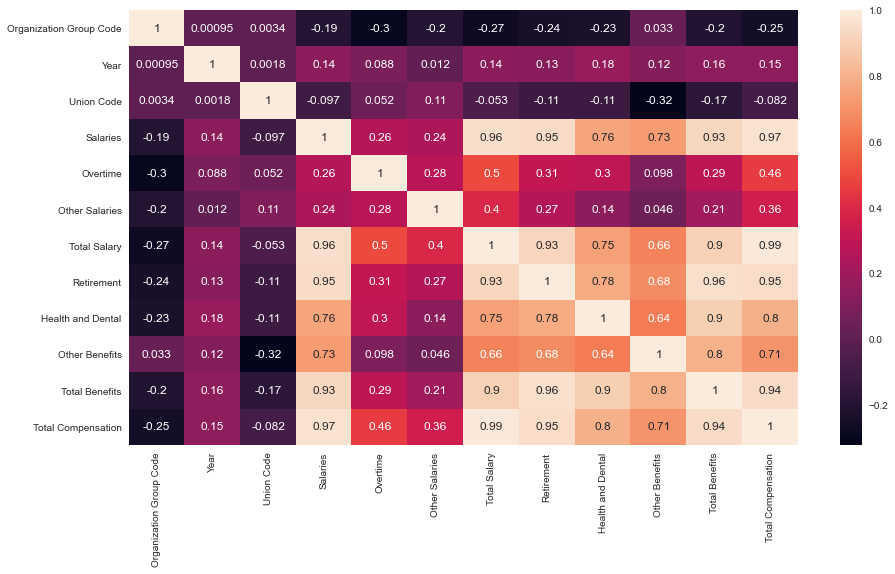

In [46]:
# Check correlation for the whole dataframe

plt.figure(figsize=(15,8))
sns.heatmap(emp_sal_fiscal.corr(), annot=True)

plt.show()

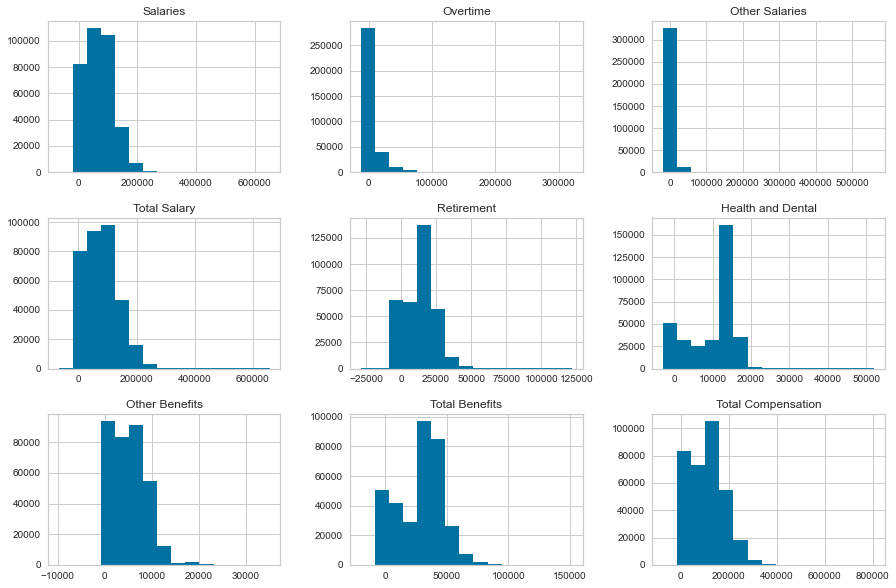

In [47]:
# check distribution for numerical column

emp_sal_fiscal[numerical.columns].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.show()

In [48]:
# Summarize of numerical features

numerical.describe()

,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
count,339243.000000,339243.000000,339243.000000,339243.000000,339243.000000,339243.000000,339243.000000,339243.000000,339243.000000
mean,69798.514048,5547.707767,3821.718786,78950.240847,13804.963794,9992.149139,5039.627591,28836.740523,107786.981370
std,48032.661587,13198.365228,8570.759144,56026.190153,10240.026894,5837.913586,3732.028966,18064.201050,72744.946957
min,-68771.780000,-12308.660000,-19131.100000,-68771.780000,-28723.190000,-2940.470000,-9857.740000,-19814.440000,-74082.610000
25%,29146.250000,0.000000,0.000000,31929.050000,4654.075000,4693.690000,1878.170000,11694.640000,44691.585000
50%,68288.810000,0.000000,697.300000,75312.490000,14036.300000,12506.550000,4906.620000,32767.850000,108194.460000
75%,100942.540000,4351.865000,4317.050000,113197.135000,20341.080000,14263.510000,7548.020000,41113.695000,155124.685000
max,651936.710000,321523.310000,560099.400000,658867.570000,121952.520000,52146.510000,35157.630000,151645.180000,807625.250000


In [49]:
# Summarize categorical features

emp_sal_fiscal.describe(include=['O'])

,Job Family Code,Job Code,Organization Group,Department Code,Department,Union,Job Family,Job
count,339243,339243,339243,339243,339243,339243,339243,339243
unique,24,1207,6,58,57,55,24,732
top,4300,9163,"Public Works, Transportation & Commerce",DPH,Public Health,"SEIU, Local 1021, Misc",Revenue,Transit Fare Inspector
freq,133163,21444,107078,74694,74694,132732,133163,21444


In [50]:
# to extract only numerical features

emp_sal_num = emp_sal_fiscal.select_dtypes(include=['float64'])
emp_sal_num

,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
339104,58368.56,0.0,0.0,58368.56,10628.94,12801.79,5254.13,28684.86,87053.42
339105,99944.00,0.0,0.0,99944.00,17700.03,12801.79,8311.72,38813.54,138757.54
339106,59585.91,0.0,0.0,59585.91,10850.65,12801.79,4461.25,28113.69,87699.60
339107,65100.00,0.0,0.0,65100.00,11529.18,8616.59,5139.40,25285.17,90385.17
339108,134251.77,0.0,0.0,134251.77,23775.87,12801.79,9733.22,46310.88,180562.65
...,...,...,...,...,...,...,...,...,...
678519,98444.94,0.0,0.0,98444.94,20540.24,15275.18,8019.49,43834.91,142279.85
678520,9416.71,0.0,0.0,9416.71,1904.43,1468.77,743.51,4116.71,13533.42
678521,96475.00,0.0,576.0,97051.00,20241.56,14100.16,7897.00,42238.72,139289.72
678522,115943.00,0.0,0.0,115943.00,24188.37,15275.18,9018.34,48481.89,164424.89


In [51]:
# to locate rows that contains negative values from numerical df

emp_sal_neg = emp_sal_num[~((emp_sal_num.loc[:,:] >= 0).all(1))]
emp_sal_neg

,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
340927,-2571.52,0.00,-520.14,-3091.66,-374.13,0.00,-52.55,-426.68,-3518.34
341646,101784.20,0.00,10178.42,111962.62,19828.63,9995.24,-25.88,29797.99,141760.61
341694,62638.98,0.00,106174.41,168813.39,12546.56,6953.59,-18.29,19481.86,188295.25
342280,-1401.03,0.00,35.38,-1365.65,-212.03,0.00,0.28,-211.75,-1577.40
342510,550.11,0.00,0.00,550.11,-0.01,0.00,569.62,569.61,1119.72
...,...,...,...,...,...,...,...,...,...
668632,-2428.50,0.00,-91.08,-2519.58,-285.42,0.00,-118.11,-403.53,-2923.11
675508,18261.29,-781.59,0.00,17479.70,0.00,0.00,1356.70,1356.70,18836.40
676873,-8392.32,0.00,0.00,-8392.32,-1603.77,-1109.66,-642.01,-3355.44,-11747.76
677037,107206.02,0.00,-312.00,106894.02,22194.07,15275.18,8691.04,46160.29,153054.31


In [52]:
# to extract rows that contains negative values from target

emp_comp_negative = emp_sal_neg[(emp_sal_neg[["Total Compensation"]] < 0).all(1)]
emp_comp_negative

,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
340927,-2571.52,0.00,-520.14,-3091.66,-374.13,0.00,-52.55,-426.68,-3518.34
342280,-1401.03,0.00,35.38,-1365.65,-212.03,0.00,0.28,-211.75,-1577.40
344439,-4503.00,0.00,3359.98,-1143.02,-697.85,0.00,-0.36,-698.21,-1841.23
345024,-2251.50,438.22,0.00,-1813.28,-339.75,0.00,-30.83,-370.58,-2183.86
348919,0.00,0.00,0.00,0.00,0.00,0.00,-29.02,-29.02,-29.02
...,...,...,...,...,...,...,...,...,...
657848,-5697.20,0.00,0.00,-5697.20,0.00,0.00,-442.20,-442.20,-6139.40
659627,-995.78,0.00,0.00,-995.78,-223.85,-249.69,-70.47,-544.01,-1539.79
665403,-7030.41,0.00,186.88,-6936.97,-1343.51,0.00,-538.53,-1882.04,-8819.01
668632,-2428.50,0.00,-91.08,-2519.58,-285.42,0.00,-118.11,-403.53,-2923.11


In [53]:
# to drop negative value from target "Total Compensation"

emp_sal_final = emp_sal_fiscal[~(emp_sal_fiscal["Total Compensation"] <= 0)]
emp_sal_final

,Organization Group Code,Job Family Code,Job Code,Year,Organization Group,Department Code,Department,Union Code,Union,Job Family,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
339104,1,8100,1021,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Legal & Court,IS Administrator 1,58368.56,0.0,0.0,58368.56,10628.94,12801.79,5254.13,28684.86,87053.42
339105,1,8100,1023,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Legal & Court,IS Administrator 3,99944.00,0.0,0.0,99944.00,17700.03,12801.79,8311.72,38813.54,138757.54
339106,1,4300,1031,2013,Public Protection,ADP,Adult Probation,790,"SEIU, Local 1021, Misc",Revenue,IS Business Analyst-Principal,59585.91,0.0,0.0,59585.91,10850.65,12801.79,4461.25,28113.69,87699.60
339107,1,8100,1054,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Legal & Court,IS Project Director,65100.00,0.0,0.0,65100.00,11529.18,8616.59,5139.40,25285.17,90385.17
339108,1,8100,1070,2013,Public Protection,ADP,Adult Probation,21,"Prof & Tech Eng, Local 21",Legal & Court,Technology Expert I,134251.77,0.0,0.0,134251.77,23775.87,12801.79,9733.22,46310.88,180562.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678519,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",98444.94,0.0,0.0,98444.94,20540.24,15275.18,8019.49,43834.91,142279.85
678520,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",9416.71,0.0,0.0,9416.71,1904.43,1468.77,743.51,4116.71,13533.42
678521,6,4300,4334,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,"Pr Investigator, Tax Collector",96475.00,0.0,576.0,97051.00,20241.56,14100.16,7897.00,42238.72,139289.72
678522,6,4300,4337,2020,General Administration & Finance,TTX,Treasurer/Tax Collector,790,"SEIU, Local 1021, Misc",Revenue,IS Business Analyst-Principal,115943.00,0.0,0.0,115943.00,24188.37,15275.18,9018.34,48481.89,164424.89


In [54]:
# check on the final dataset for visualisation

emp_sal_final.nunique()

Organization Group Code         6
Job Family Code                24
Job Code                     1207
Year                            8
Organization Group              6
Department Code                58
Department                     57
Union Code                     58
Union                          55
Job Family                     24
Job                           732
Salaries                   257572
Overtime                   143110
Other Salaries             171264
Total Salary               314697
Retirement                 236336
Health and Dental          108843
Other Benefits             284899
Total Benefits             318969
Total Compensation         331628
dtype: int64

#### Summary of exploring the dataset and descriptive analysis of the dataframe: 
#### Data findings from top view
- There are 8 years data from 6 organization group data from the city San Fransico which contains 58 different department and it had been grouped into 24 Job Family. 
- From the distribution plot of numerical columns, we observed that there are negative values for most of the columns including the Target. 
>- It may due to the adjustment of wages, benefits have overpaid or employees have leave the the organization but the benefit had been overclaimed. By health and dental wise, it is a group insurance that covered by year hence the organization may have to recover back as well.
>-Example, an employee who was overpaid at the end of Fiscal year 2013 with an adjustment to correct the mistake not occurring until the beginning of Fiscal year 2014. If the employee did not receive other payment in FY2014 for the same department and job, the report would show only this adjustment for the employee as a negative amount. 
- There may have zero dollar amounts. Zero-dollar amounts could be a separated employee receiving a one-time payout of accrued vacation hours but no other salary or benefits during the period. Hence the employee will have zero amount in "Salaries","Overtime" or other benefits categories and only have "Other Salaries". 
- It has outlier due to the negative values from all numerical columns however we will not drop the negative values except for "Total Compensation". As negative values needed to be use for prediction as it is one of the records affect the total from the forecasting. 
- Among all the features correlation, all the categorical features are not correlated with numerical features. However it is normal for numerical features is related as the sum of all the features is the target feature.

- The top count from categorical variable of the dataset: 
    * Organization Group - Public Works, Transportation and Commerce
    * Department - Public Health
    * Job - Transit Fare Inspector
    * Job Family - Revenue


### Data Insights, Findings and Visualization

#### 1. Which Organization Group has the highest compensation? 

In [55]:
# create new dataframe to show compensation by organization group

ave_com = emp_sal_final.groupby(["Organization Group"]).agg({"Total Compensation":["sum","count","mean"]}).reset_index()
ave_com

Organization Group Total Compensation          \
                                                           sum   count   
0                          Community Health       7.844595e+09   74654   
1                      Culture & Recreation       1.664377e+09   31245   
2          General Administration & Finance       3.166727e+09   30813   
3  Human Welfare & Neighborhood Development       2.363956e+09   30337   
4                         Public Protection       9.845120e+09   64944   
5   Public Works, Transportation & Commerce       1.168158e+10  107027   

                  
            mean  
0  105079.370706  
1   53268.592886  
2  102772.421082  
3   77923.195399  
4  151593.983445  
5  109146.094862

In [56]:
# check on the column name 
ave_com.columns.get_level_values(0)

Index(['Organization Group', 'Total Compensation', 'Total Compensation',
       'Total Compensation'],
      dtype='object')

In [57]:
# to renew the column
replacement_col_list6 = list(ave_com.columns.get_level_values(0))
replacement_col_list6[1] = "Sum of Compensation"
replacement_col_list6[2] = "Total"
replacement_col_list6[3] = "Average of Compensation"

In [58]:
# check the column naming after rename
replacement_col_list6

['Organization Group',
 'Sum of Compensation',
 'Total',
 'Average of Compensation']

In [59]:
# map the column name
ave_com.columns = replacement_col_list6

In [60]:
# sort the dataframe
ave_com = ave_com.sort_values(by = "Average of Compensation",ascending = False)

In [61]:
# check and view the dataframe
ave_com

,Organization Group,Sum of Compensation,Total,Average of Compensation
4,Public Protection,9.845120e+09,64944,151593.983445
5,"Public Works, Transportation & Commerce",1.168158e+10,107027,109146.094862
0,Community Health,7.844595e+09,74654,105079.370706
2,General Administration & Finance,3.166727e+09,30813,102772.421082
3,Human Welfare & Neighborhood Development,2.363956e+09,30337,77923.195399
1,Culture & Recreation,1.664377e+09,31245,53268.592886


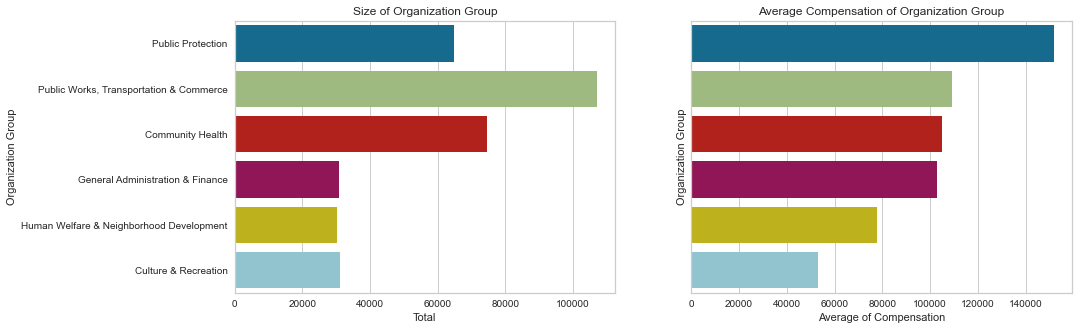

In [62]:
# Comparing the size against average compensation of Organization Group 

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sns.barplot(ax=axes[0],x="Total",y="Organization Group",data=ave_com)
sns.barplot(ax=axes[1],x="Average of Compensation",y="Organization Group",data=ave_com)
axes[0].set_title("Size of Organization Group")
axes[1].set_title("Average Compensation of Organization Group")
plt.show()


In [63]:
# check on the trend of Compensation by Organization Group
yearly_trend = emp_sal_final.pivot_table(values= ["Total Compensation"], index=emp_sal_final["Year"], columns=emp_sal_final["Organization Group"], aggfunc=np.median)

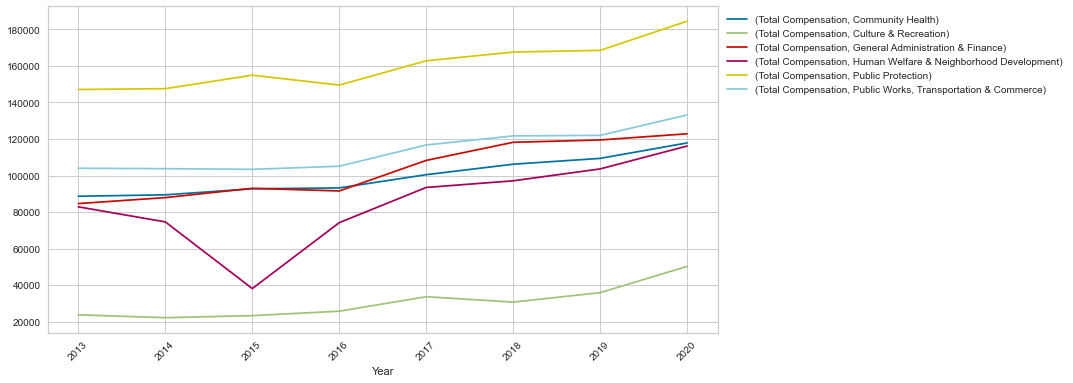

In [64]:
# plot yearly trend

yearly_trend.plot(figsize=(12,6), grid=True)

plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.show()

From the bar chart, we can see that Public Protection have the highest compensation among all the other organization even though it did not have the highest count. It could be due to their nature of their job as protecting the public as fire fighter or police. 
Although the count of Community Health is double from General Admin and Finance, their average compensation is the same.

We observed that from the line chart, there is a drop of 50% from the organization group - Human Welfare & Neighborhood Development. 



#### 2. How did the compensation change over the year? 

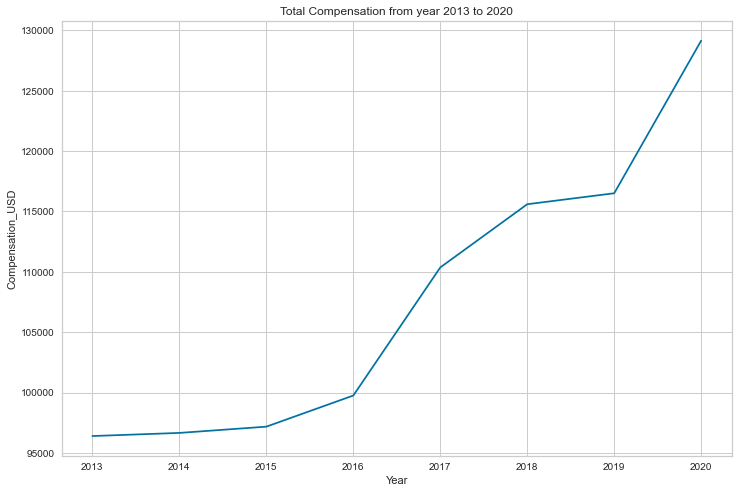

In [65]:
# plot chart for Total Compensation by Year

plt.figure(figsize=(12,8))
sns.lineplot(x = "Year", y = "Total Compensation", data = emp_sal_final,ci=None)
plt.ylabel("Compensation_USD")
plt.title("Total Compensation from year 2013 to 2020")
plt.show()

We can see from the chart, year 2013 to 2015 are more consistent as compared to year 2016 to 2017 and year 2019 to 2020 that have more  incremental amount. 

After 2-3 years of consistency, there is a rise in the compensation of at least 10%. The surge in 2017 and 2020 could be low turnover rate which will have more increment of salary and benefits. 


#### 3. Which is the top 10 department with the highest count and what is their salaries and overtime claims? 

In [66]:
# create new dataframe for salary and overtime information by department

dept_sal = emp_sal_final.groupby("Department").agg({"Department":"count","Salaries":"mean","Overtime":"mean"})

In [67]:
# check on the column
dept_sal.columns.get_level_values(0)

Index(['Department', 'Salaries', 'Overtime'], dtype='object')

In [68]:
# to rename the column
replacement_col_list1 = list(dept_sal.columns.get_level_values(0))
replacement_col_list1[0] = "Count"

In [69]:
replacement_col_list1

['Count', 'Salaries', 'Overtime']

In [70]:
# to replace the column
dept_sal.columns = replacement_col_list1

In [71]:
#sort the dataframe 
dept_sal = dept_sal.sort_values(by = "Count",ascending = False).head(10)

In [72]:
# view the dataframe
dept_sal

,Count,Salaries,Overtime
Department,,,
Public Health,74654,70505.402994,2692.572603
Municipal Transportation Agcy,50511,62560.213892,10814.643330
Human Services,26640,50999.722410,847.012215
Police,26380,96845.597692,13979.260027
Recreation And Park Commission,19602,27425.002311,1014.340294
Airport Commission,15843,69911.351056,2000.068912
Fire Department,14633,105404.309325,22288.139754
Public Utilities Commission,14054,85060.927358,2618.098696
Department Of Public Works,13143,68480.817587,1846.622630


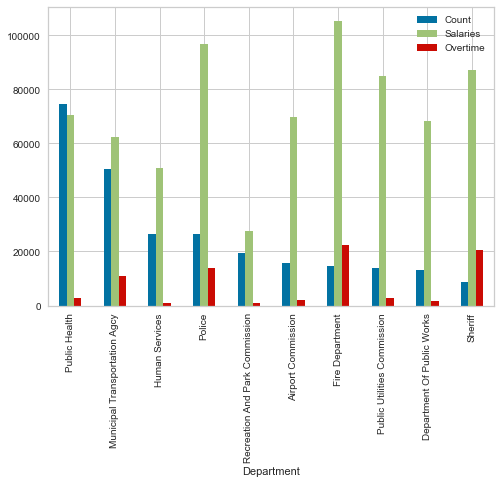

In [73]:
#plot the chart to visualise the differenece between salary and overtime with the count. 
dept_sal.plot(kind="bar")
plt.show()

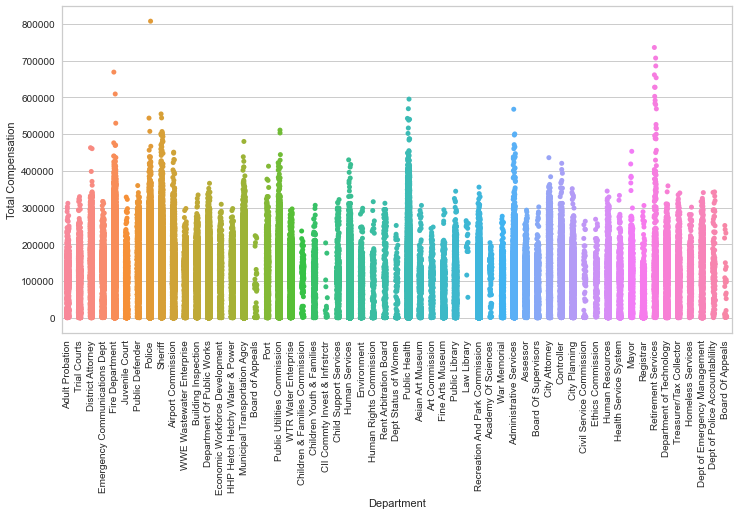

In [74]:
# plot the compensation by department 

plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.stripplot(x="Department", y="Total Compensation", data=emp_sal_final)

plt.show()

In [75]:
# check on the compensation by year and department

sum_year = emp_sal_final.groupby(["Year","Department"])["Total Compensation"].mean().sort_values(ascending=False)
sum_year

Year  Department 
2020  Law Library    234638.410000
2019  Law Library    231240.510000
2016  Law Library    225946.045000
2018  Law Library    221387.730000
2017  Law Library    218580.245000
                         ...      
      Registrar       19846.103994
2016  Registrar       19640.633090
2015  Registrar       19422.933057
2013  Registrar       19333.774137
2020  Registrar       16405.939966
Name: Total Compensation, Length: 412, dtype: float64

- Based on the chart, we can see that the number in Public Health is inline with the Salaries paid out but OT claims is lesser. It could be due to their role not require OT and also refer to contract that certain threshold of salary range there will be no overtime claims. 
-Fire Department have the highest salaries and overtime claims followed by Police among the top 10 department, this could be their work nature is more high risk and greater responsibilities compared to others. Hence the City attract people to take up the job by giving more remuneration as it is essential and this is a job that required passion.

- From the above stripplot, can see that Law Library have lesser headcount but their compensation is higher due to their job nature. There is also an outlier from Police that is the most highest compensation, this could be the person holding high position or the claim to the person at a one-time paid out. 

#### 4. Is the nature of the job affect their health and dental or salaries? 

In [76]:
# Group by year and job and show the top 10 count. 

year_job = emp_sal_final.groupby("Year")["Job"].value_counts().nlargest(10)
year_job


Year  Job                   
2019  Transit Fare Inspector    3011
2016  Transit Fare Inspector    2819
2015  Transit Fare Inspector    2772
2017  Transit Fare Inspector    2742
2020  Transit Fare Inspector    2741
2018  Transit Fare Inspector    2732
2014  Transit Fare Inspector    2324
2013  Transit Fare Inspector    2299
2018  Public Health Nurse       1653
2019  Public Health Nurse       1651
Name: Job, dtype: int64

In [77]:
# manipulate dataframe for the details from the feature "Job"

job_com = emp_sal_final.groupby(["Job"]).agg({"Total Compensation":["count","mean"],
                                              "Salaries":"mean",
                                             "Health and Dental":"mean"}).reset_index()
job_com

Job Total Compensation                 \
                                                 count           mean   
0       ACPO,JuvP, Juv Prob (SFERS)                  8  149607.572500   
1         ASR Operations Supervisor                177   90645.896949   
2      ASR Senior Office Specialist                249   65320.822811   
3              ASR-Office Assistant                 40   38919.899500   
4                     Account Clerk               2047   98191.740508   
..                              ...                ...            ...   
727                    Wharfinger 2                 15  121677.265333   
728                  Window Cleaner                  8  125900.923750   
729       Window Cleaner Supervisor                  5  126601.212000   
730  WireRopeCable Maint Mech Train                 73  159578.655342   
731      Worker's Comp Supervisor 1                206  114325.490534   

          Salaries Health and Dental  
              mean              mean  
0    102054.155000      15729.845000  
1     61522.420847      11286.793729  
2     42987.171647       9813.021165  
3     25259.789250       6404.780000  
4     65996.269184      11595.639355  
..             ...               ...  
727   84783.906000      12715.733333  
728   86487.835000      13590.277500  
729   88426.478000      13501.794000  
730   79281.219178      12333.362877  
731   79682.654854      12120.448932  

[732 rows x 5 columns]

In [78]:
# to show the column naming
job_com.columns.get_level_values(0)

Index(['Job', 'Total Compensation', 'Total Compensation', 'Salaries',
       'Health and Dental'],
      dtype='object')

In [79]:
# to rename the column

replacement_col_list5 = list(job_com.columns.get_level_values(0))
replacement_col_list5[1] = "Count"
replacement_col_list5[2] = "Average of Compensation"
replacement_col_list5[3] = "Average of Salaries"
replacement_col_list5[4] = "Average of Health and Dental"


In [80]:
# replace the column name
job_com.columns = replacement_col_list5

In [81]:
# show the dataframe by sorting the size 

job_com = job_com.sort_values(by = "Count",ascending = False)
job_com

,Job,Count,Average of Compensation,Average of Salaries,Average of Health and Dental
686,Transit Fare Inspector,21440,96366.785885,52985.094664,11444.607673
516,Public Health Nurse,12548,45648.925017,35634.193819,810.054410
132,Clinical Nurse Specialist,11034,166224.617600,109706.573817,12109.601439
225,EMT/Paramedic/Firefighter,6982,174649.207004,98895.884610,14780.140126
140,Communications Line Wrk Sprv 2,6963,11425.460409,7762.933193,2016.117336
...,...,...,...,...,...
158,"Court Asst, Superior Court",1,66705.330000,41107.020000,6101.530000
426,Mobile Equipment Supervisor,1,20195.140000,0.000000,0.000000
170,Court Supervisor I,1,36903.690000,0.000000,0.000000
701,Trial Delay Reduct Coord,1,6573.110000,4579.520000,718.560000


In [82]:
# check on the top 10 job's compensation, salaries and health and dental giveen

top_10_job = job_com[:10]
top_10_job

,Job,Count,Average of Compensation,Average of Salaries,Average of Health and Dental
686,Transit Fare Inspector,21440,96366.785885,52985.094664,11444.607673
516,Public Health Nurse,12548,45648.925017,35634.193819,810.054410
132,Clinical Nurse Specialist,11034,166224.617600,109706.573817,12109.601439
225,EMT/Paramedic/Firefighter,6982,174649.207004,98895.884610,14780.140126
140,Communications Line Wrk Sprv 2,6963,11425.460409,7762.933193,2016.117336
591,Sergeant 2,6818,169770.841049,106502.620034,11917.858282
183,Custodial Assistant Supervisor,6745,77328.325081,47325.127663,11139.674463
531,Recreation Specialist,5838,9304.817622,7341.643407,1084.786257
64,Attorney (Civil/Criminal),5833,19066.088411,12656.177619,3543.739834
501,Principal Account Clerk,5661,93396.715231,61706.106317,11666.038253


In [83]:
# check on the less job 

last_10_job = job_com[-10:]
last_10_job

,Job,Count,Average of Compensation,Average of Salaries,Average of Health and Dental
31,Apprentice Maint Machinist 1,1,111340.24,72179.48,16715.49
379,"Manager II, MTA",1,80712.89,74899.50,0.00
473,Pianist,1,4552.04,4218.76,0.00
156,Court Adr Coord,1,6709.69,4707.00,738.57
430,Musm Exhibit Packer & Repairer,1,9487.87,6952.42,1997.20
158,"Court Asst, Superior Court",1,66705.33,41107.02,6101.53
426,Mobile Equipment Supervisor,1,20195.14,0.00,0.00
170,Court Supervisor I,1,36903.69,0.00,0.00
701,Trial Delay Reduct Coord,1,6573.11,4579.52,718.56
490,Police Services Aide,1,3944.57,2947.93,0.00


- Transit Fare Inspector has the most headcount in San Francisco City but their salaries and compensation is not the highest as it may due to blue collar nature of work. 
-Public Health Nurse has the lowest Health and Dental as all the medical expenses is under the hospital cost.
-Among the top 10 of Job, we know that EMT/Paramedic/Firefighter is the high risk job hence their health and dental coverage is the highest. 


#### 5. Will the health and dental's budget allocate to the right organization group needed? 

In [84]:
# Check on health and dental by Organization Group

health_den = emp_sal_final.groupby("Organization Group").agg({"Organization Group":"count","Health and Dental":"mean"})

In [85]:
health_den

,Organization Group,Health and Dental
Organization Group,,
Community Health,74654,9123.955406
Culture & Recreation,31245,6254.419169
General Administration & Finance,30813,9527.577744
Human Welfare & Neighborhood Development,30337,8863.975272
Public Protection,64944,12129.470249
"Public Works, Transportation & Commerce",107027,10866.152671


In [86]:
# check on the size of department by organization group

organ_dept = emp_sal_final.groupby(["Organization Group","Department"]).size()

In [87]:
# check on the department from the Organizartion has highest health and dental

organ_dept["Public Protection"]

Department
Adult Probation                    1418
Dept of Emergency Management       1010
Dept of Police Accountablility      152
District Attorney                  2599
Emergency Communications Dept      1496
Fire Department                   14633
Juvenile Court                     2491
Police                            26380
Public Defender                    1554
Sheriff                            8780
Trial Courts                       4431
dtype: int64

Based on the table above, as explained previously on question 3 that "Public Protection" are more high risk job hence the budget of health and dental is the highest followed by Public Works, Transportation & Commerce.

#### 6. Total Salary vs Total Benefits

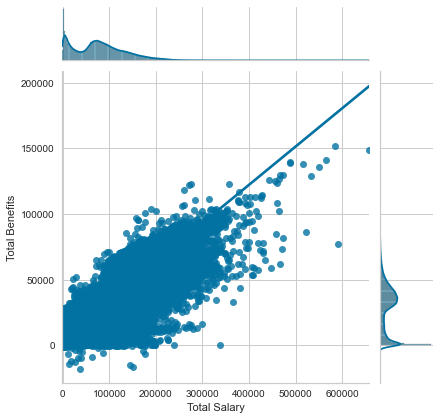

In [88]:
sns.jointplot("Total Salary" , "Total Benefits", data = emp_sal_final , kind = "reg")
plt.show()

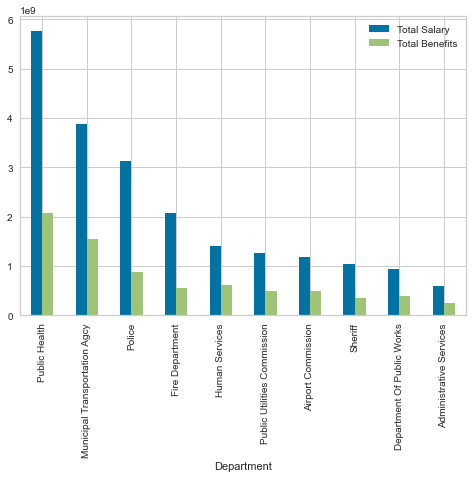

In [89]:
# groupby data for total salary and total benefits by department and sort by total salary

emp_sal_final.groupby(["Department"])["Total Salary","Total Benefits"].sum().sort_values(by="Total Salary",ascending=False).head(10).plot(kind='bar')
plt.show()

#### 7. What is the yearly trend of the top 10 jobs? 

In [90]:
# check on the size of job by department

dept_job = emp_sal_final.groupby(["Department","Job"]).size().nlargest(10)
dept_job

Department                      Job                      
Municipal Transportation Agcy   Transit Fare Inspector       21433
Public Health                   Public Health Nurse          12548
                                Clinical Nurse Specialist    10985
Fire Department                 EMT/Paramedic/Firefighter     6977
Police                          Sergeant 2                    6719
Recreation And Park Commission  Recreation Specialist         5838
Police                          Police Officer 2              5171
Human Services                  Attorney (Civil/Criminal)     4920
Public Health                   Psychiatric Technician        4747
Sheriff                         Senior Deputy Sheriff         4384
dtype: int64

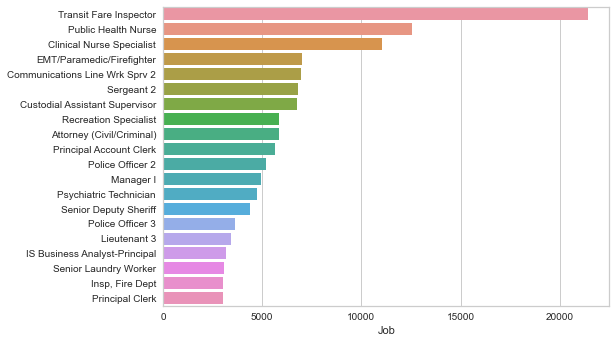

In [91]:
# visualise top 20 job over 8 years

jobcount = emp_sal_final["Job"].value_counts()[:20]
sns.barplot(x=jobcount,y=jobcount.keys())
plt.show()

- From what this plot displays, it appears that Transit Fare Inspector take up a large majority of the basis of jobs throughout San Francisco, and the second most common job being a Public Health Nurse. I am not completely sure the difference between what a Police Officer 2 or Police Officer 3 is, although they seem to be quite relative and distributed throughout the city. The smallest from this list on top twenty that I used was a Principal Clerk, which it could make sense as there appears not to be an incredibly high demand or demographic/experience to fulfill this job title making it less popular than other jobs such as Transit Fare Inspector. Lastly, I’d like to look at the most popular jobs in the city of San Francisco throughout all available years in the dataset.

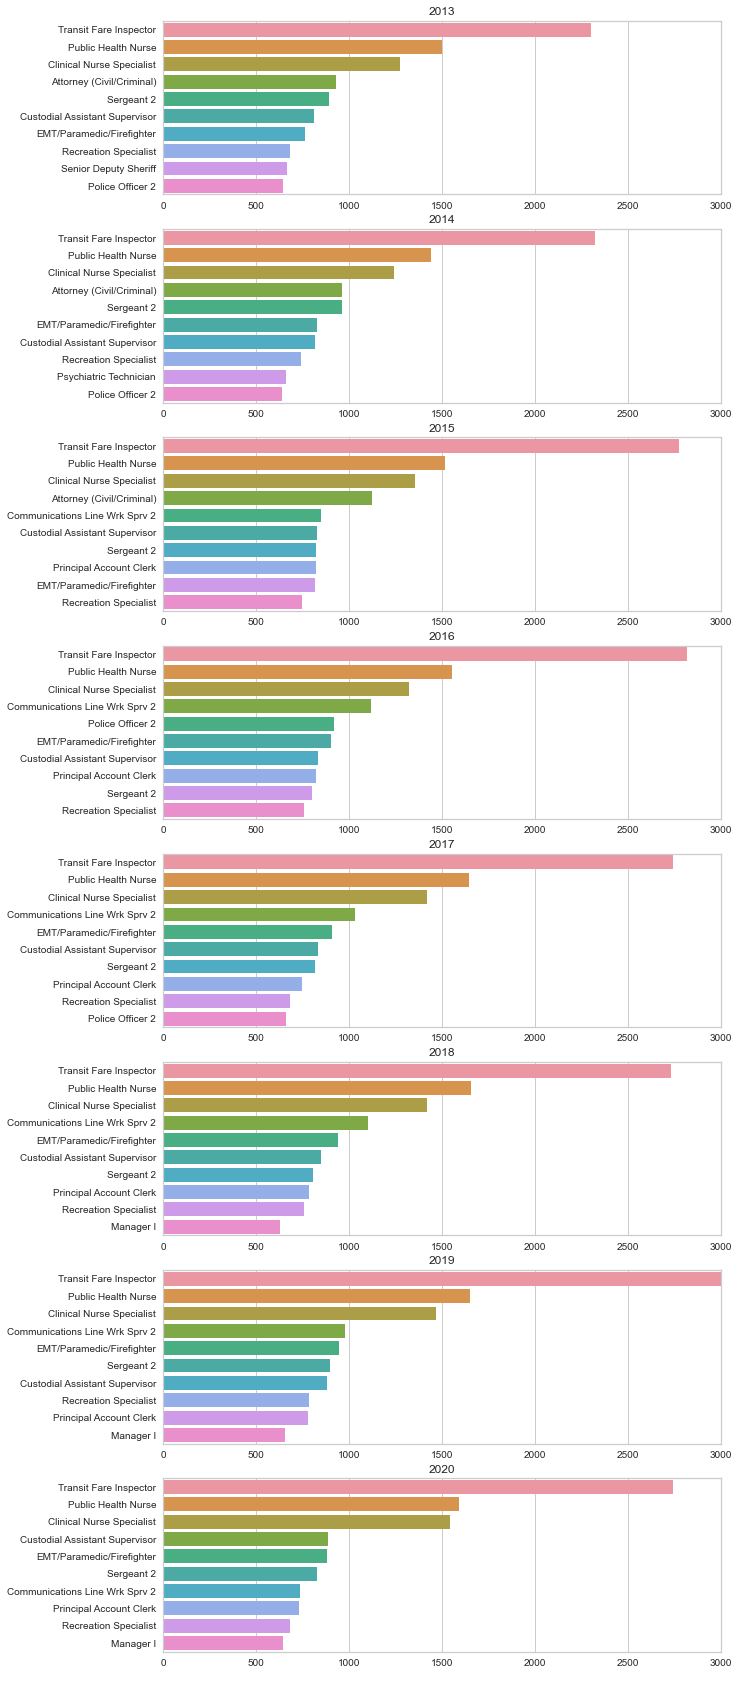

In [92]:
# visualise count of the top 10 "Job" over the years

fig,ax = plt.subplots(8, figsize = (10,30))
for i in range (8):
    jcount = emp_sal_final[emp_sal_final["Year"] == (2013 +i)]["Job"].value_counts()[:10]
    sns.barplot(x=jcount, y=jcount.keys(), ax=ax[i])
    ax[i].set_title(str(2013+i))
    ax[i].set_xlabel(" ")
    ax[i].set_xlim(0,3000)

The common trend throughout all eight years in this dataset shows little variation across the top cumulative job titles, although you can see that the number transit fare inspector appears to be growing within the city. Most other jobs also see small increases, but this could simply just be due to increased population number over the years. 

In [93]:
# manipulate dataframe on the yearly trend 

yearly_job = emp_sal_final.pivot_table(values= ["Job"], index=emp_sal_final["Year"], aggfunc=len)

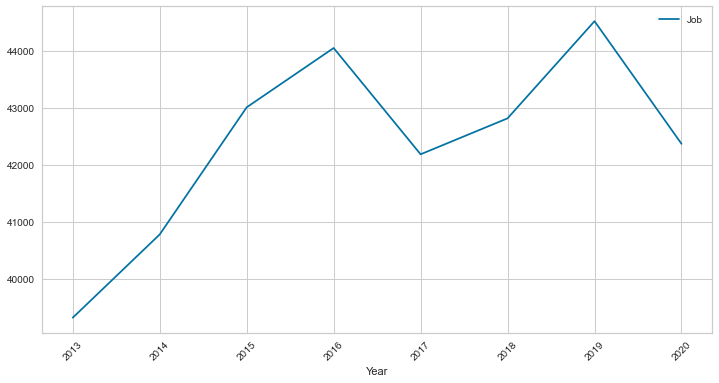

In [94]:
# plot the data as above 

yearly_job.plot(figsize=(12,6), grid=True)

plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

#### Separate dataframe into separate object

In [95]:
# copy dataframe 

empcomp = emp_sal_final.copy()

In [96]:
empcomp.nunique()

Organization Group Code         6
Job Family Code                24
Job Code                     1207
Year                            8
Organization Group              6
Department Code                58
Department                     57
Union Code                     58
Union                          55
Job Family                     24
Job                           732
Salaries                   257572
Overtime                   143110
Other Salaries             171264
Total Salary               314697
Retirement                 236336
Health and Dental          108843
Other Benefits             284899
Total Benefits             318969
Total Compensation         331628
dtype: int64

In [97]:
# drop unwanted features for predictive model 

empcomp = empcomp.drop(["Organization Group Code","Job Family Code","Job Code","Department Code","Union Code","Union",
                       "Job","Total Salary","Total Benefits"],axis=1)


In [98]:
empcomp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339020 entries, 339104 to 678523
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                339020 non-null  int64  
 1   Organization Group  339020 non-null  object 
 2   Department          339020 non-null  object 
 3   Job Family          339020 non-null  object 
 4   Salaries            339020 non-null  float64
 5   Overtime            339020 non-null  float64
 6   Other Salaries      339020 non-null  float64
 7   Retirement          339020 non-null  float64
 8   Health and Dental   339020 non-null  float64
 9   Other Benefits      339020 non-null  float64
 10  Total Compensation  339020 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 39.1+ MB


In [99]:
# reset index 

empcomp.reset_index()

,index,Year,Organization Group,Department,Job Family,Salaries,Overtime,Other Salaries,Retirement,Health and Dental,Other Benefits,Total Compensation
0,339104,2013,Public Protection,Adult Probation,Legal & Court,58368.56,0.0,0.0,10628.94,12801.79,5254.13,87053.42
1,339105,2013,Public Protection,Adult Probation,Legal & Court,99944.00,0.0,0.0,17700.03,12801.79,8311.72,138757.54
2,339106,2013,Public Protection,Adult Probation,Revenue,59585.91,0.0,0.0,10850.65,12801.79,4461.25,87699.60
3,339107,2013,Public Protection,Adult Probation,Legal & Court,65100.00,0.0,0.0,11529.18,8616.59,5139.40,90385.17
4,339108,2013,Public Protection,Adult Probation,Legal & Court,134251.77,0.0,0.0,23775.87,12801.79,9733.22,180562.65
...,...,...,...,...,...,...,...,...,...,...,...,...
339015,678519,2020,General Administration & Finance,Treasurer/Tax Collector,Revenue,98444.94,0.0,0.0,20540.24,15275.18,8019.49,142279.85
339016,678520,2020,General Administration & Finance,Treasurer/Tax Collector,Revenue,9416.71,0.0,0.0,1904.43,1468.77,743.51,13533.42
339017,678521,2020,General Administration & Finance,Treasurer/Tax Collector,Revenue,96475.00,0.0,576.0,20241.56,14100.16,7897.00,139289.72
339018,678522,2020,General Administration & Finance,Treasurer/Tax Collector,Revenue,115943.00,0.0,0.0,24188.37,15275.18,9018.34,164424.89


In [100]:
# target vector
y = empcomp["Total Compensation"]

# feature matrix 
X = empcomp.drop(columns = ["Total Compensation"])

In [101]:
# check dtype of y 
y.dtypes

dtype('float64')

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339020 entries, 339104 to 678523
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                339020 non-null  int64  
 1   Organization Group  339020 non-null  object 
 2   Department          339020 non-null  object 
 3   Job Family          339020 non-null  object 
 4   Salaries            339020 non-null  float64
 5   Overtime            339020 non-null  float64
 6   Other Salaries      339020 non-null  float64
 7   Retirement          339020 non-null  float64
 8   Health and Dental   339020 non-null  float64
 9   Other Benefits      339020 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 36.5+ MB


#### Encoding Categorical Values

In [103]:
# OHE is used for features that turn into 0,1 (since Organization Group and Job Family are not ordinal)

X = pd.get_dummies(X, columns=["Organization Group", "Job Family"])

X.head().T

,339104,339105,339106,339107,339108
Year,2013,2013,2013,2013,2013
Department,Adult Probation,Adult Probation,Adult Probation,Adult Probation,Adult Probation
Salaries,58368.56,99944.0,59585.91,65100.0,134251.77
Overtime,0.0,0.0,0.0,0.0,0.0
Other Salaries,0.0,0.0,0.0,0.0,0.0
Retirement,10628.94,17700.03,10850.65,11529.18,23775.87
Health and Dental,12801.79,12801.79,12801.79,8616.59,12801.79
Other Benefits,5254.13,8311.72,4461.25,5139.4,9733.22
Organization Group_Community Health,0,0,0,0,0
Organization Group_Culture & Recreation,0,0,0,0,0


In [104]:
# calculate the len of Department

count_dept = X.Department.value_counts()

In [105]:
# use Frequency encoding for Department

encode_dept = count_dept/len(X.Department)
X["dept_enc"] = X.Department.map(count_dept)

X.head().T

,339104,339105,339106,339107,339108
Year,2013,2013,2013,2013,2013
Department,Adult Probation,Adult Probation,Adult Probation,Adult Probation,Adult Probation
Salaries,58368.56,99944.0,59585.91,65100.0,134251.77
Overtime,0.0,0.0,0.0,0.0,0.0
Other Salaries,0.0,0.0,0.0,0.0,0.0
Retirement,10628.94,17700.03,10850.65,11529.18,23775.87
Health and Dental,12801.79,12801.79,12801.79,8616.59,12801.79
Other Benefits,5254.13,8311.72,4461.25,5139.4,9733.22
Organization Group_Community Health,0,0,0,0,0
Organization Group_Culture & Recreation,0,0,0,0,0


In [106]:
# drop the original feature of Department after encode

X.drop(["Department"], axis=1, inplace=True)

#### Create a Train Test Split

In [107]:
# Data will be splitting into train_test using train_test_split() with the test size of 20% of the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [108]:
# check on the train test is split equally same as orginally y to avoid any imbalance data

sum(y_train)/len(y_train)

107797.9615163933

In [109]:
# check on the test set is split equally same as originally to avoid any imbalance data

sum(y_test)/len(y_test)

108103.09037770673

In [110]:
# check on "y" data types and ensure it is in numerical

y_train.dtypes

dtype('float64')

In [111]:
# make sure train test split shape is all the same

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(271216, 38) (67804, 38) (271216,) (67804,)


In [112]:
# make a copy before scaling

X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

#### Feature Scaling

In [113]:
# scale columns that have huge rage which is more than 10

sc = StandardScaler()

ss_col = X.columns[1:7]

for item in ss_col:
    X_train_scale[item] = sc.fit_transform(X_train[[item]])
    X_test_scale[item] = sc.fit_transform(X_test[[item]])

In [114]:
# check on column selected 

X.columns[1:7]  

Index(['Salaries', 'Overtime', 'Other Salaries', 'Retirement',
       'Health and Dental', 'Other Benefits'],
      dtype='object')

In [115]:
# view dataframe after scale

X_train_scale.head().T 

,501855,661431,597143,413012,606507
Year,2016.000000,2020.000000,2019.000000,2014.000000,2019.000000
Salaries,-0.150709,-0.372025,0.667522,0.098350,0.614879
Overtime,-0.338006,-0.420150,1.401580,-0.420150,0.361317
Other Salaries,-0.303998,-0.451162,-0.111132,-0.382778,0.334386
Retirement,-0.191593,-0.286467,0.559371,0.215635,0.626964
Health and Dental,0.518122,0.176912,0.943840,0.273039,1.048607
Other Benefits,0.081429,-0.266421,-0.771619,0.318530,1.157988
Organization Group_Community Health,0.000000,1.000000,0.000000,0.000000,0.000000
Organization Group_Culture & Recreation,1.000000,0.000000,0.000000,1.000000,0.000000
Organization Group_General Administration & Finance,0.000000,0.000000,0.000000,0.000000,0.000000


### Model Selection and trainings

In [116]:
# create dataframe using for loop to fit 10 models into the training set and check the metric results of each model 

metric_score = pd.DataFrame(columns=["model", "MAE", "MSE", "RMSE", "R2"])

model_test = {"DT":DecisionTreeRegressor(), "RF":RandomForestRegressor(), "LR":LinearRegression(),\
              "GB":GradientBoostingRegressor(),"XGB":XGBRegressor(), "ET":ExtraTreesRegressor(),\
              "HGB":HistGradientBoostingRegressor(),"EL":ElasticNet(),"AB":AdaBoostRegressor(),"KN":KNeighborsRegressor()}

counter = 0
for n, m in model_test.items():
    base_model = m.fit(X_train_scale, y_train)
    y_pred = base_model.predict(X_test_scale)
    metric_score.loc[counter, :] = n, mean_absolute_error(y_test , y_pred), mean_squared_error(y_test, y_pred),\
    np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test,y_pred)

    counter += 1

print(metric_score)

  model          MAE               MSE          RMSE        R2
0    DT   1582.96705   12701968.989066   3563.982181  0.997588
1    RF   952.720417    5540407.797668   2353.807086  0.998948
2    LR   812.674334    3514773.755877   1874.772988  0.999333
3    GB  2162.101329   11129592.078538   3336.104327  0.997886
4   XGB  1339.204868    5042895.325087    2245.63918  0.999042
5    ET   723.208584    3986937.892553   1996.731803  0.999243
6   HGB  1519.634027    12833578.28867   3582.398399  0.997563
7    EL  9243.999993  160319247.846479  12661.723731  0.969554
8    AB  22465.52707  739967098.203611  27202.336264  0.859474
9    KN  2823.047665   35540737.834126   5961.605307  0.993251


### Hyperparameter optimization

To optimize the parameters we will use GridSearch, an exhaustive search with a selected subset of relevant hyperparameters. Scikit-learn has a library specially dedicated to this task : GridSearchCV, we will use it with 5-fold cross-validation.

### 1. Random Forest Regressor

In [117]:
# Fitting Random Forest Regressor to the Training set
# random state is important to set if you want to produce the same results, to ensure bootstrapping is same

base_rf = RandomForestRegressor(random_state = 42)

In [118]:
# set the parameters for tuning
# n estimators = The number of trees in the forest.
# max_depth = the maximum depth of the tress.

param_dict_rf = {"n_estimators":[110,120,130,140],
                 "max_depth" : [29,30,33,35],
                 "max_features": ["auto"]}

In [119]:
# fitting the parameters for tuning

grid_model_rf = GridSearchCV(estimator= base_rf, param_grid = param_dict_rf, n_jobs=-1)

In [120]:
# fit the training set after tuning

grid_model_rf.fit(X_train_scale, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [29, 30, 33, 35],
                         'max_features': ['auto'],
                         'n_estimators': [110, 120, 130, 140]})

In [121]:
# to get the best parameters

grid_model_rf.best_params_

{'max_depth': 33, 'max_features': 'auto', 'n_estimators': 140}

__Parameters' adjustment__

Attempt 1:
> max_depth:27
> n_estimors:100

Attempt 2:
> max_depth:
    27,30 return 30 as the best<br>
> n_estimors: 
    100,130 return 100 as the best

Attempt 3:
> max_depth:
    27,30,50 return 30 as the best<br>
> n_estimors: 
    80,100,130 return 100 as the best


Attempt 4:
> max_depth:
    29,30,33,35 return 33 as the best<br>
> n_estimors: 
    130,150,170 return 130 as the best

Attempt 5:
> max_depth:
    29,30,33,35 return 33 as the best<br>
> n_estimors: 
    100,110,120,130,140 return 140 as the best
    

- The best parameters for Random Forest algorithm at {"max_depth": 33, "n_estimators": 140}, using "n_estimators": [100,110,120,130,140] , "max_depth": [29,30,33,35].

In [122]:
# using the best parameters to predict on test set and check metric results

y_pred_rf = grid_model_rf.predict(X_test_scale)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Mean Absolute Error: 951.667821289096
Mean Squared Error: 5461883.542572286
Root Mean Squared Error: 2337.0672952596565
R2 Score: 0.9989627401703612


In [123]:
# comparison of the metrics results before tune

metric_score.iloc[[1]]

,model,MAE,MSE,RMSE,R2
1,RF,952.720417,5540407.797668,2353.807086,0.998948


In [124]:
# plot feature importance

f_imp2 = pd.DataFrame(columns = ["feature", "importance"], index = range(38))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i,0] = X_train_scale.columns.to_list()[i]
f_imp2["importance"] = grid_model_rf.best_estimator_.feature_importances_
f_imp2 = f_imp2.sort_values("importance", ascending = False)
f_imp2[0:12].style.background_gradient(cmap = "Blues")

,feature,importance
1,Salaries,0.892466
4,Retirement,0.055742
2,Overtime,0.029045
6,Other Benefits,0.014007
3,Other Salaries,0.006816
5,Health and Dental,0.001616
0,Year,0.000096
35,Job Family_Street Transit,0.000066
37,dept_enc,0.000034
26,Job Family_Police Services,0.000015


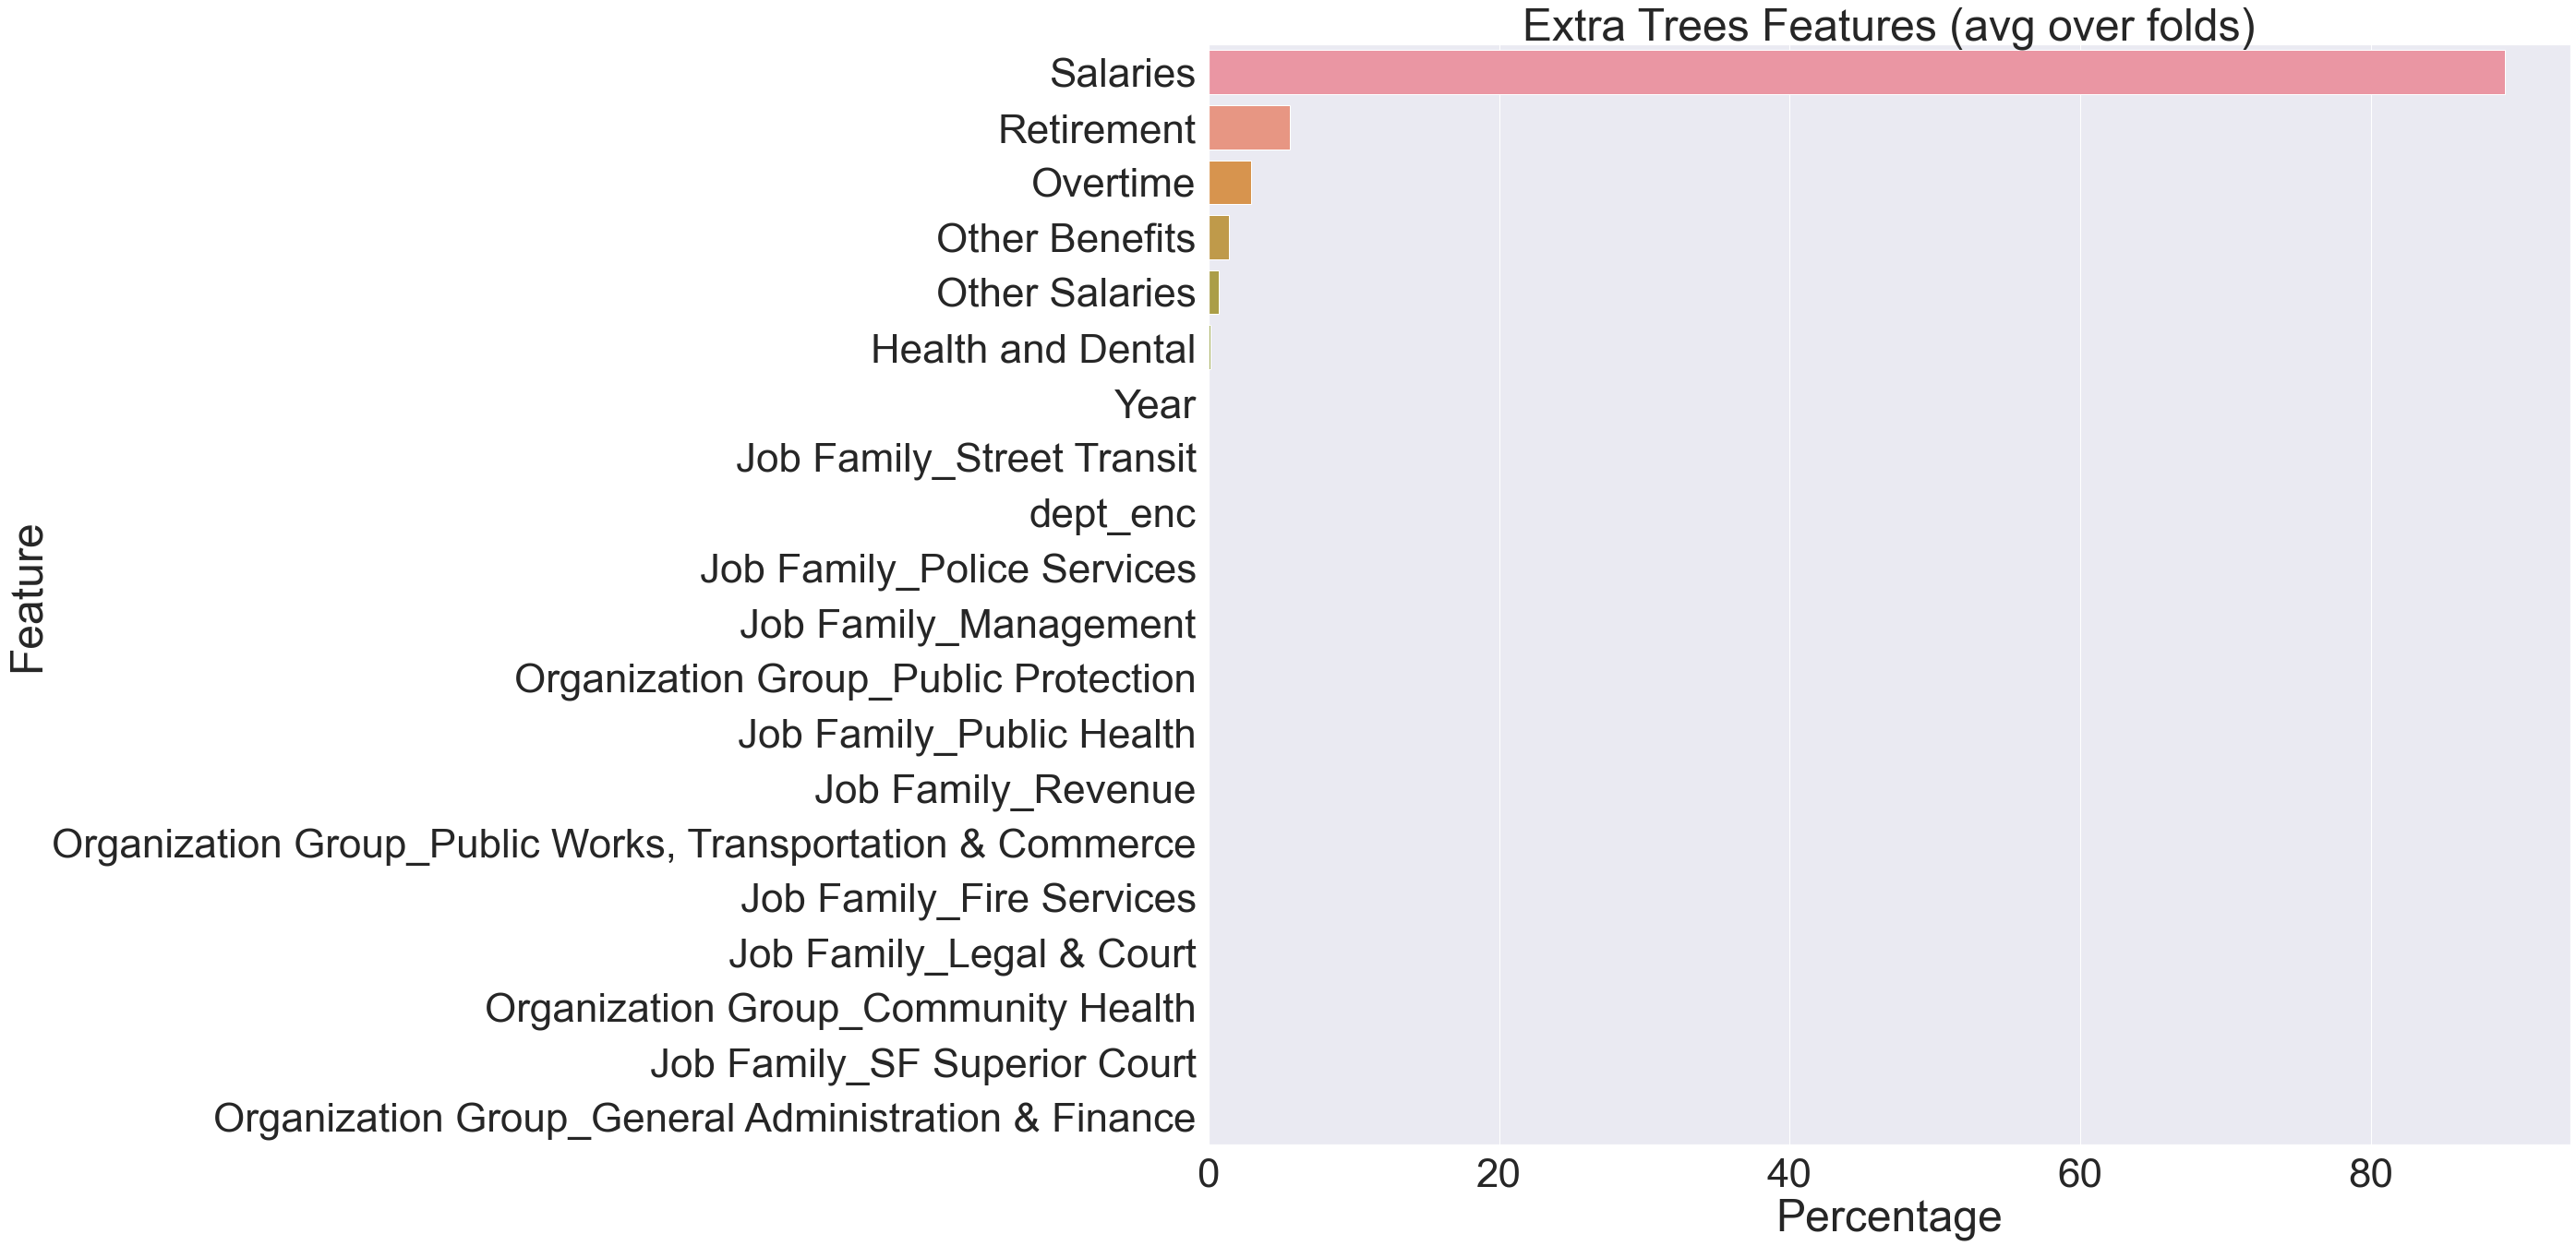

In [125]:
# plot feature importance for Random Forest algorithm

plotImp(grid_model_rf.best_estimator_,X_train_scale)


Based on model Random Forest, we can see that "Salaries" is the highest weightage of 89% among all features. After tuning, there is not much improvement as well. 

### 2. Extra Tree Regressor

In [126]:
# Fitting Extra Tree Regressor to the Training set
# random state is important to set if you want to produce the same results, to ensure bootstrapping is same

base_et = ExtraTreesRegressor(random_state = 42)

In [127]:
# set the parameters for tuning
# n estimators = The number of trees in the forest.
# max_depth = the maximum depth of the tress.

param_dict_et = {"n_estimators":[300,320,350],
                 "max_depth" : [27,33,38]}

In [128]:
# fitting the parameters for tuning

grid_model_et = GridSearchCV(estimator= base_et, param_grid = param_dict_et , cv=5 , verbose=1, n_jobs=-1)

In [129]:
# fit the training set after tuning

grid_model_et.fit(X_train_scale, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 139.2min finished


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [27, 33, 38],
                         'n_estimators': [300, 320, 350]},
             verbose=1)

In [130]:
# to get the best parameters

grid_model_et.best_params_

{'max_depth': 33, 'n_estimators': 300}

__Parameters' adjustment__

Attempt 1:
> max_depth:33
> n_estimors:100

Attempt 2:
> max_depth:
    27,33,38 return 33 as the best<br>
> n_estimors: 
    80,100,130 return 130 as the best

Attempt 3:
> max_depth:
    27,33,38 return 33 as the best<br>
> n_estimors: 
    130,170,200 return 200 as the best

Attempt 4:
> max_depth:
    27,33,38 return 33 as the best<br>
> n_estimors: 
    200,250,300 return 300 as the best

Attempt 5:
> max_depth:
     27,33,38 return 33 as the best<br>
> n_estimors: 
    300,320,350 return 300 as the best
    

- The best parameters for Extra Trees algorithm at {"max_depth": 33, "n_estimators": 300}, using "n_estimators": [300,320,350], "max_depth": [27,33,38].

In [131]:
# using the best parameters to predict on test set and check metric results

y_pred_et = grid_model_et.predict(X_test_scale)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_et))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_et))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_et)))
print("R2 Score:", r2_score(y_test, y_pred_et))

Mean Absolute Error: 722.776508461268
Mean Squared Error: 3920279.7490683286
Root Mean Squared Error: 1979.9696333702516
R2 Score: 0.9992555043195337


In [132]:
# comparison of the metrics results before tune

metric_score.iloc[[5]]

,model,MAE,MSE,RMSE,R2
5,ET,723.208584,3986937.892553,1996.731803,0.999243


In [133]:
# plot feature importance

f_imp2 = pd.DataFrame(columns = ["feature", "importance"], index = range(38))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i,0] = X_train_scale.columns.to_list()[i]
f_imp2["importance"] = grid_model_et.best_estimator_.feature_importances_
f_imp2 = f_imp2.sort_values("importance", ascending = False)
f_imp2[0:12].style.background_gradient(cmap = "Blues")

,feature,importance
1,Salaries,0.317464
4,Retirement,0.262234
5,Health and Dental,0.180690
6,Other Benefits,0.109664
31,Job Family_Revenue,0.052704
2,Overtime,0.032186
11,Organization Group_Public Protection,0.023092
3,Other Salaries,0.008669
35,Job Family_Street Transit,0.003152
8,Organization Group_Culture & Recreation,0.001367


In [134]:
# plot feature importance

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({"Percentage":(model.feature_importances_ / sum(model.feature_importances_) * 100),
                                "Feature":X.columns})
    plt.figure(figsize=(40,20))
    sns.set(font_scale = 4)
    sns.barplot(x="Percentage", y="Feature", data=feature_imp.sort_values(by="Percentage", 
                                                        ascending=False)[0:num])
    plt.title('Extra Trees Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

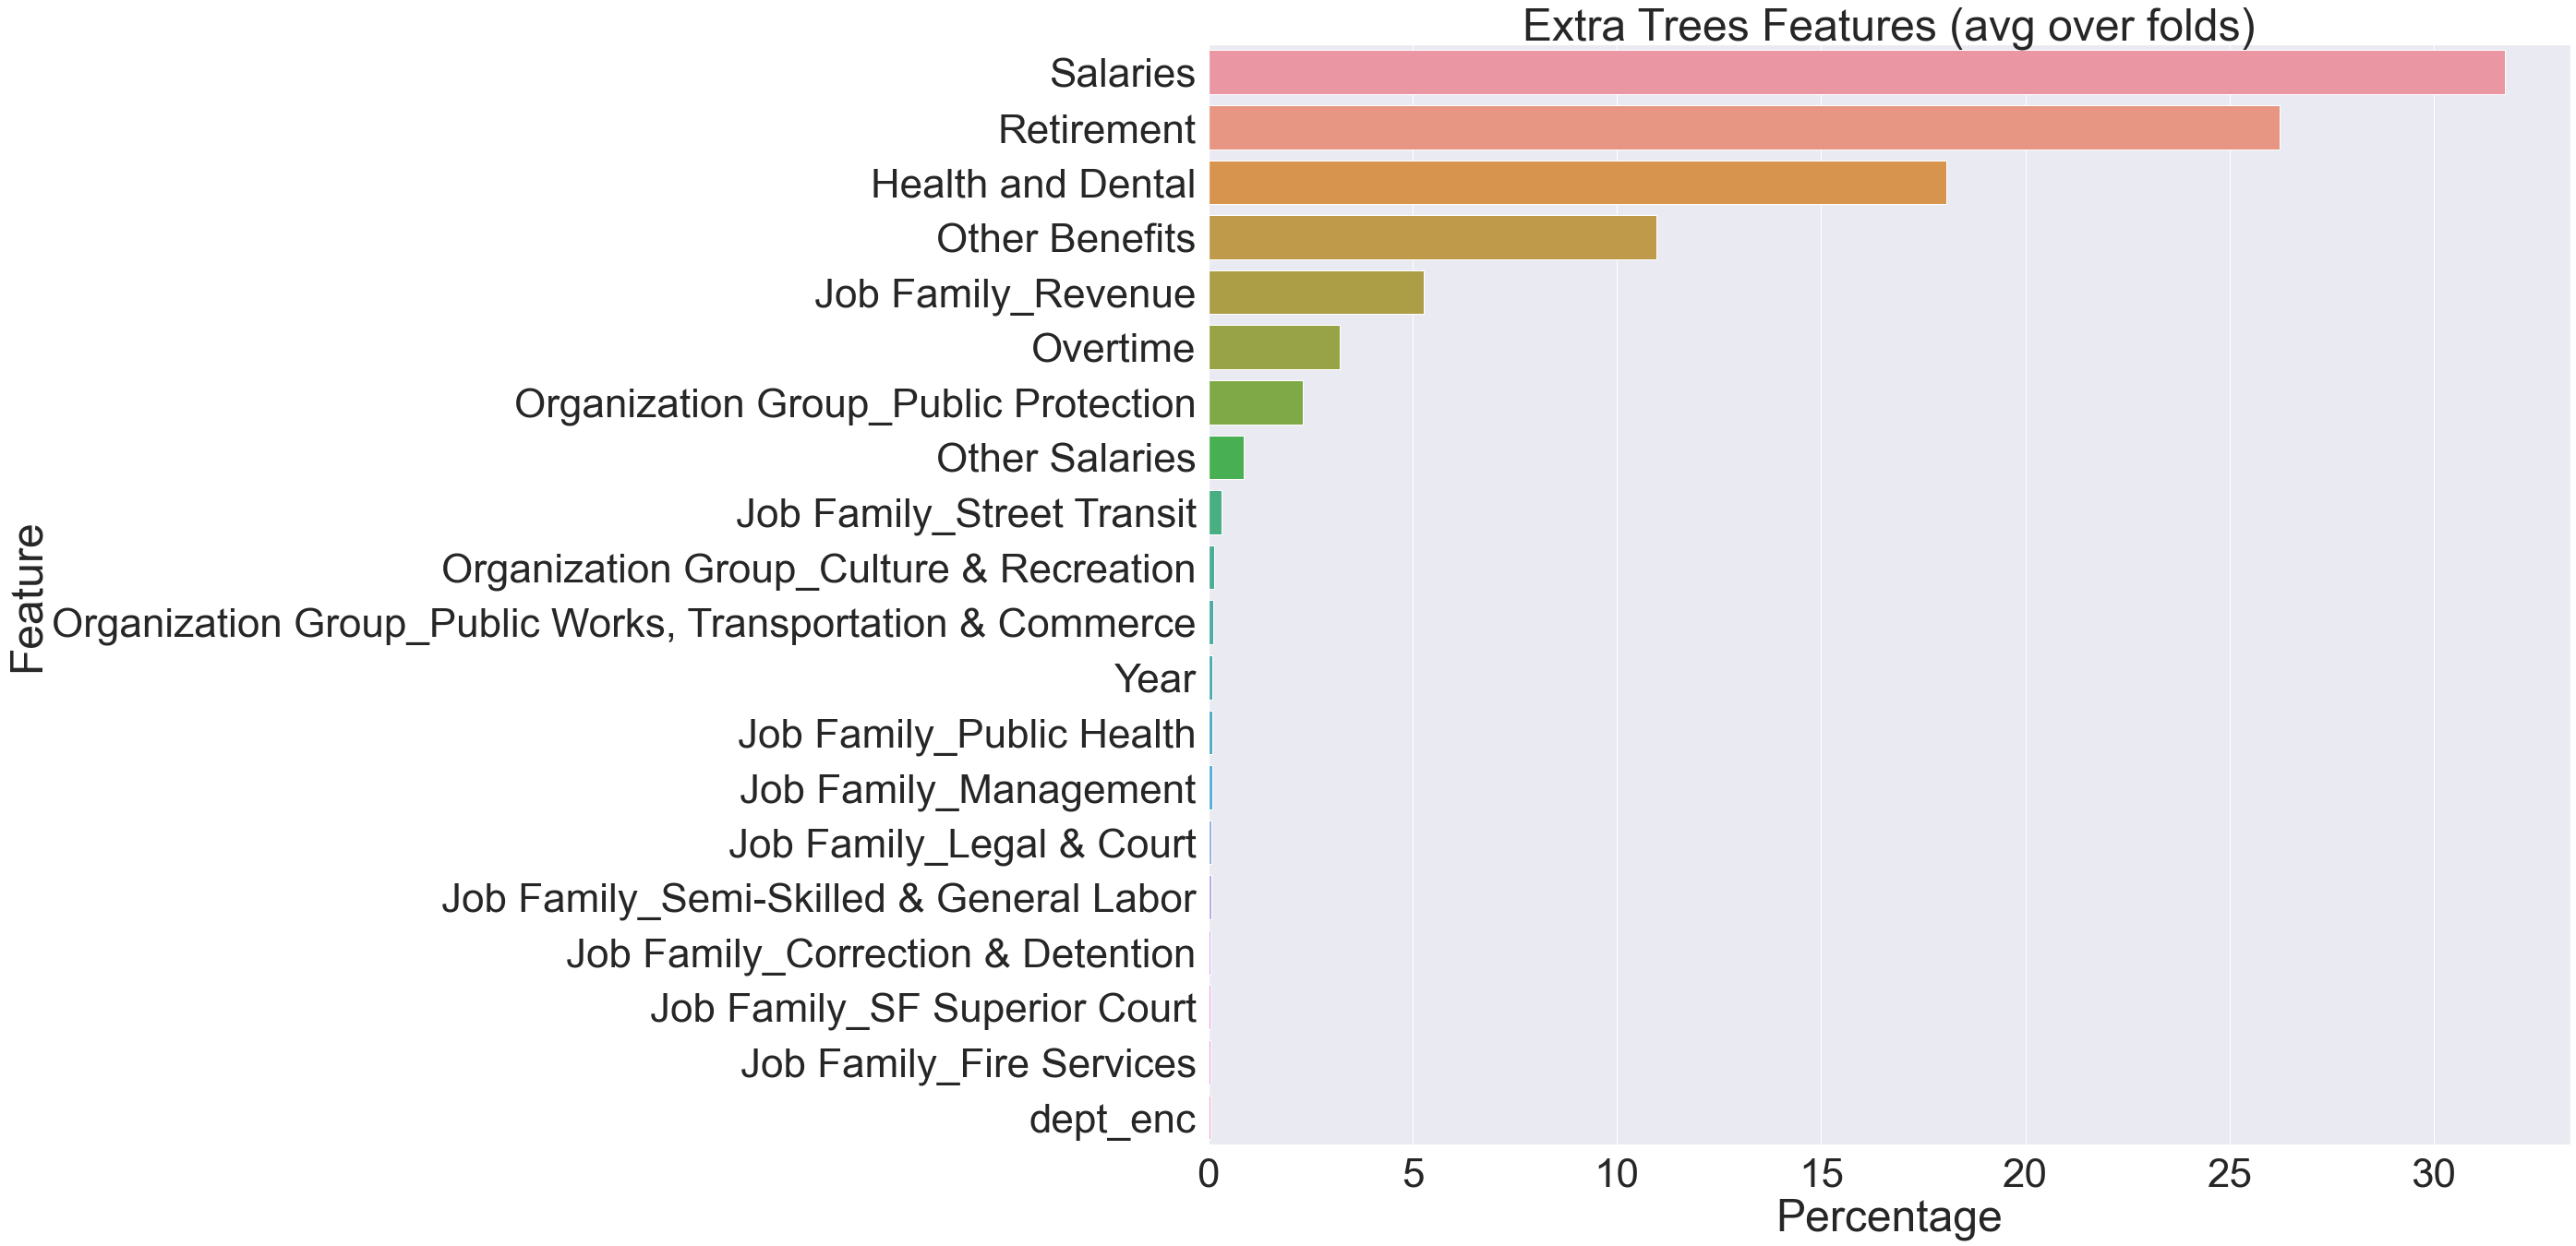

In [135]:
plotImp(grid_model_et.best_estimator_,X_train_scale)

#### Obeservation: 

Based on feature importance, we can see that salaries is 30% weightage among 38 features that we have included in the training model and followed by retirement of 25%. This 2 features have taken up half of the weightage and it is common to have “Salaries” holding the highest weightage as it is a basic requirement. San Francisco City is providing the employees with a good benefits of retirement to ease their worries after they retired. However, “Overtime” and “Other Salaries” were less than 5%. This shows that San Francisco City is taking care of their employees’ work life balance because of the employees clock lesser overtime. 


### Model Evaluation and Comparison

In [136]:
# fitting the training set into the top 3 models with the best parameters after tuning to whow all results in one table

final_results = pd.DataFrame(columns=["model", "MAE", "MSE", "RMSE", "R2"])

best_tuned_3_model = {"RandomForest":RandomForestRegressor(max_depth = 33, n_estimators = 140,random_state = 42), 
                      "ExtraTree":ExtraTreesRegressor(random_state=42,n_estimators = 300, max_depth = 33),                                          
                      "LinearRegression":LinearRegression()}

counter = 0
for k, model in best_tuned_3_model.items():
    best_model = model.fit(X_train_scale, y_train)
    y_pred2 = best_model.predict(X_test_scale)
    final_results.loc[counter, :] = k, mean_absolute_error(y_test , y_pred2), mean_squared_error(y_test, y_pred2),\
    np.sqrt(mean_squared_error(y_test, y_pred2)), r2_score(y_test,y_pred2)
    counter += 1
    
print (final_results)

              model         MAE             MSE         RMSE        R2
0      RandomForest  951.667821  5461883.542572  2337.067295  0.998963
1         ExtraTree  722.776508  3920279.749068  1979.969633  0.999256
2  LinearRegression  812.674334  3514773.755877  1874.772988  0.999333


#### Check on the percentage of Total Compensation of the MAE of the model Extra Tree (MAPE)

In [137]:
check_percent_et = np.mean(np.abs(y_test - y_pred_et))/np.mean(np.abs(y_test))*100
check_percent_et

0.6685993026988677

#### Conclusion

The aim of this study was to create regression models for the employee salary compensation dataset and to predict the compensation paid out by creating models and to obtain lower mean absolute error in the established models. The work done is as follows:

1) Compensation Data Set read.

2) With Exploratory Data Analysis; The data set's structural data were checked. The types of variables in the dataset were examined. Size information of the dataset was accessed. Descriptive statistics of the data set were examined. It was concluded that there were missing observations and outliers in the data set.

4) During Model Building; Random Forests, XGBoost, AdaBoost, ExtraTress, DecisionTrees, Linear Regression, Gradient Boosting, Histogram Gradient Boosting, Elastic Net and K Neighbors like using machine learning models mean absolute error was calculated. Later Random Forests, and Extra Tree hyperparameter optimizations optimized to improve the metric results. 

5) Result; The best model performance is Extra Tree Regressor because it has the lowest average discrepancy between actual and predicted value. Compared to other models which do not have improvement after tuning. Extra Tree Regressor can forecast the compensation with mean absolute percentage error (MAPE) of 0.67% which are a very good results with a lower error rate. 

##### Insights/Recommendation: 
The prediction model is able to help The San Francisco Controller's Office to have better planning of their budget and resources to help prevent under or over estimations and maintain a stable calculation through the years to come. It can also help the city to request more manpower cost if they know in advance. 

The City may have more time to requisite funds for essential stuff to make good of the city and provide maintenance of the public places after having sufficient fund for their manpower cost. They can take this opportunity to cut cost on certain department and provide adequate remuneration for the lower wage jobs. 
